# Predicting California Housing Prices
We will use the California Housing Prices dataset. This dataset was based on data from the 1990 California census. It is not exactly recent, but it has many qualities for learning, so we will pretend it is recent data.

Dataset columns description:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [34]:
# Data manipulation and Linear Algebra
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Sklearn for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [35]:
# load data
df = pd.read_csv('housing.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### Some Insights:
- we have 10 columns (9 numerical, and 1 categorical).
- we have 20640 rows.
- we have missing data in total_bedrooms.

In [37]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [38]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

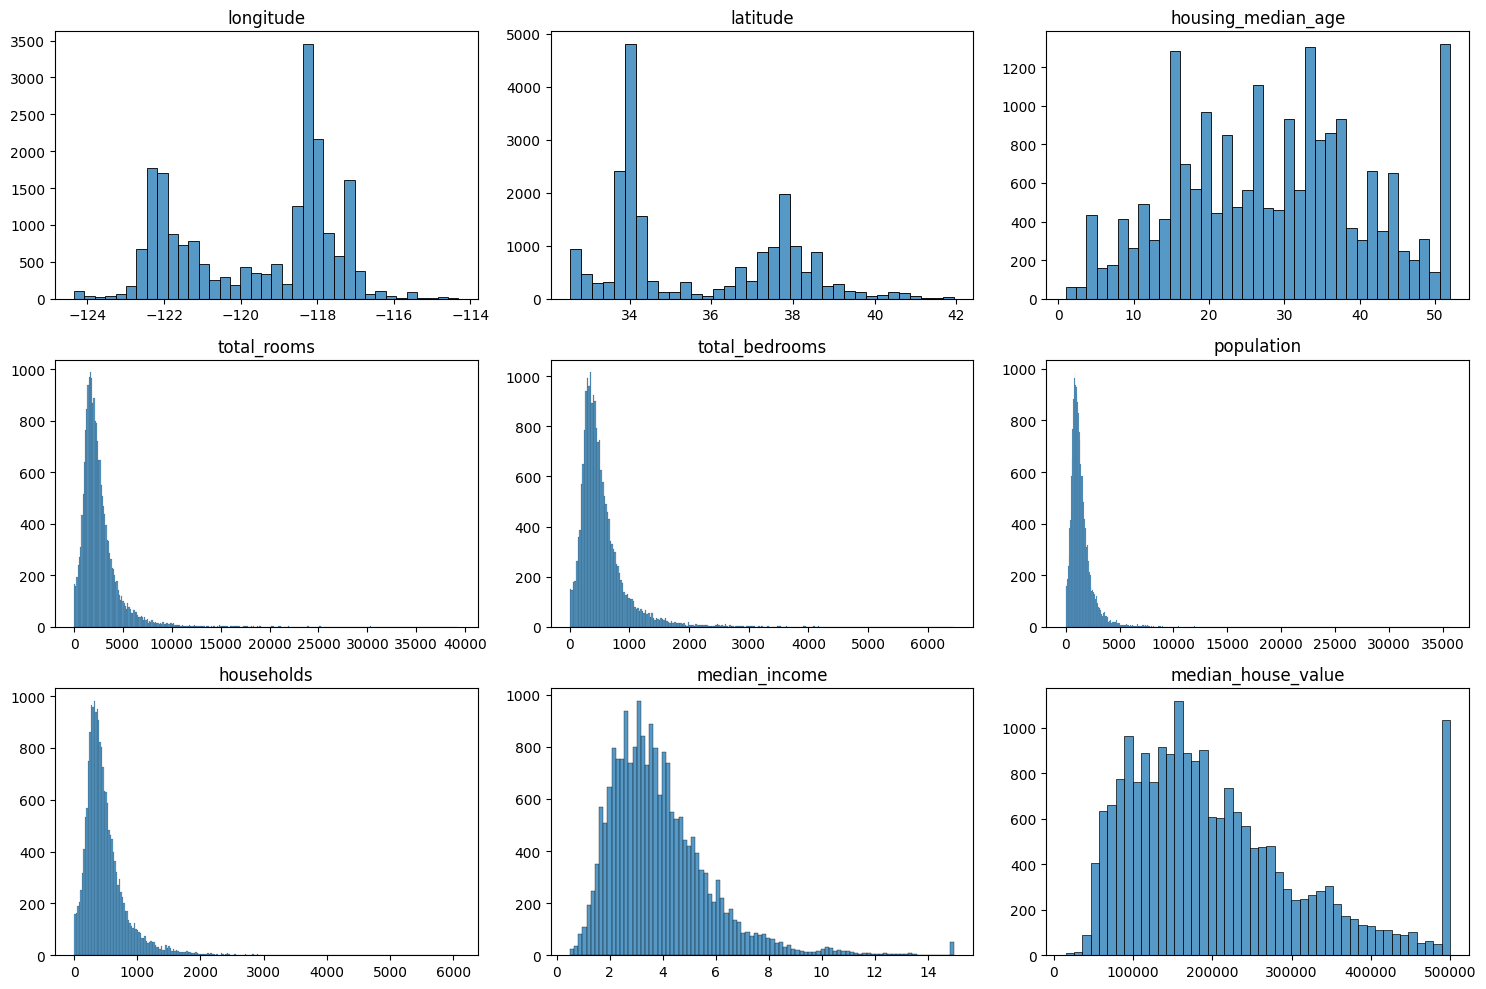

In [39]:
# Plot Histograms to know more about the numerical data distrbutions.
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.histplot(df[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

##### Some Insights:
- Median Income isn't look like US Dollars (it ranges from 0.5 to 15), and after searching it may be divided by 10000$ and capped the values bigger than 15 to 15.
- There are tall bars in the max value of median_house_value and housing_median_ages and that indicator of capping the values of the houses expencive more than 500K $ and older than 50 years old, and that's can be a problem because our problem might learn there isn't prices can't exceed 500k dollars, Maybe we will need to remove these capped rows to not bad influence our model.
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left. 

In [40]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

#### Train test split:
It's good to split our data to train and test sets, as soon as possiable to prevent what called data snoping bias.

In [41]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)
df = train_set.copy()

### 1. Data Preproccessing:

#### 1.1 Checking for Dublicates:

In [42]:
print("Number of Duplicates: ", df.duplicated().sum())

Number of Duplicates:  0


#### 1.2 Checking for Outliers:

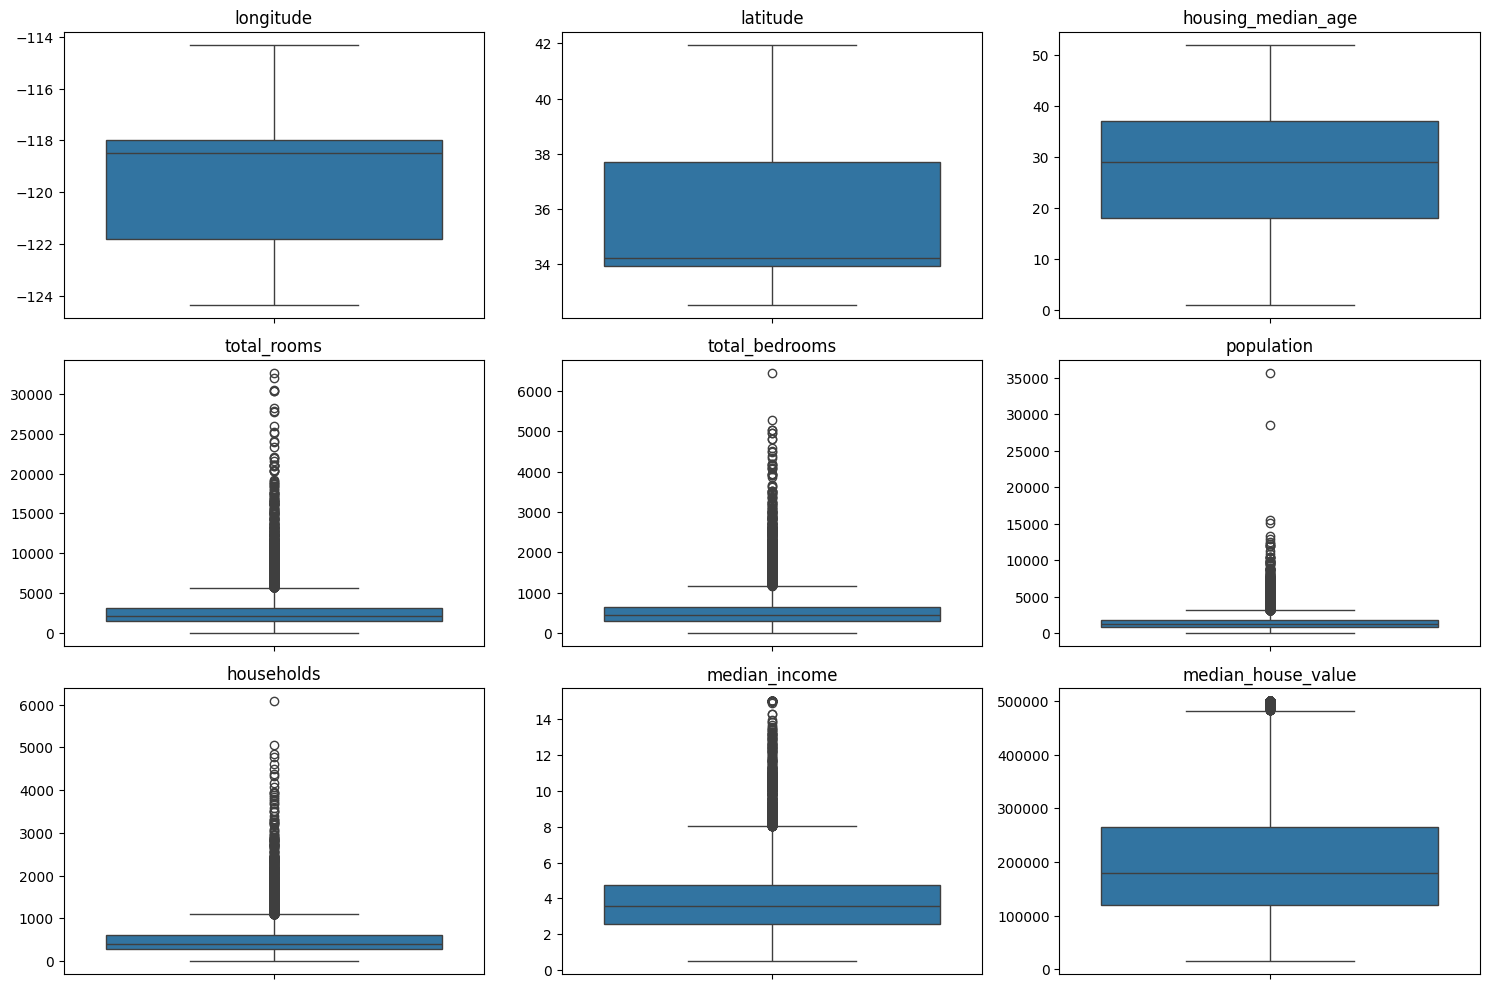

In [43]:
# Plot Histograms to know more about the numerical data distrbutions.
fig, axes = plt.subplots(3,3, figsize=(15, 10))
num_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

for name, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(df[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

Okay, As before we have upperbonds outliers in (total rooms, total bedrooms, population, households, median income). I think (total rooms, total bedrooms) is really dependant on number of households on the district. And I think there is a big correlations between (total rooms, total bedrooms, population, households, median income).

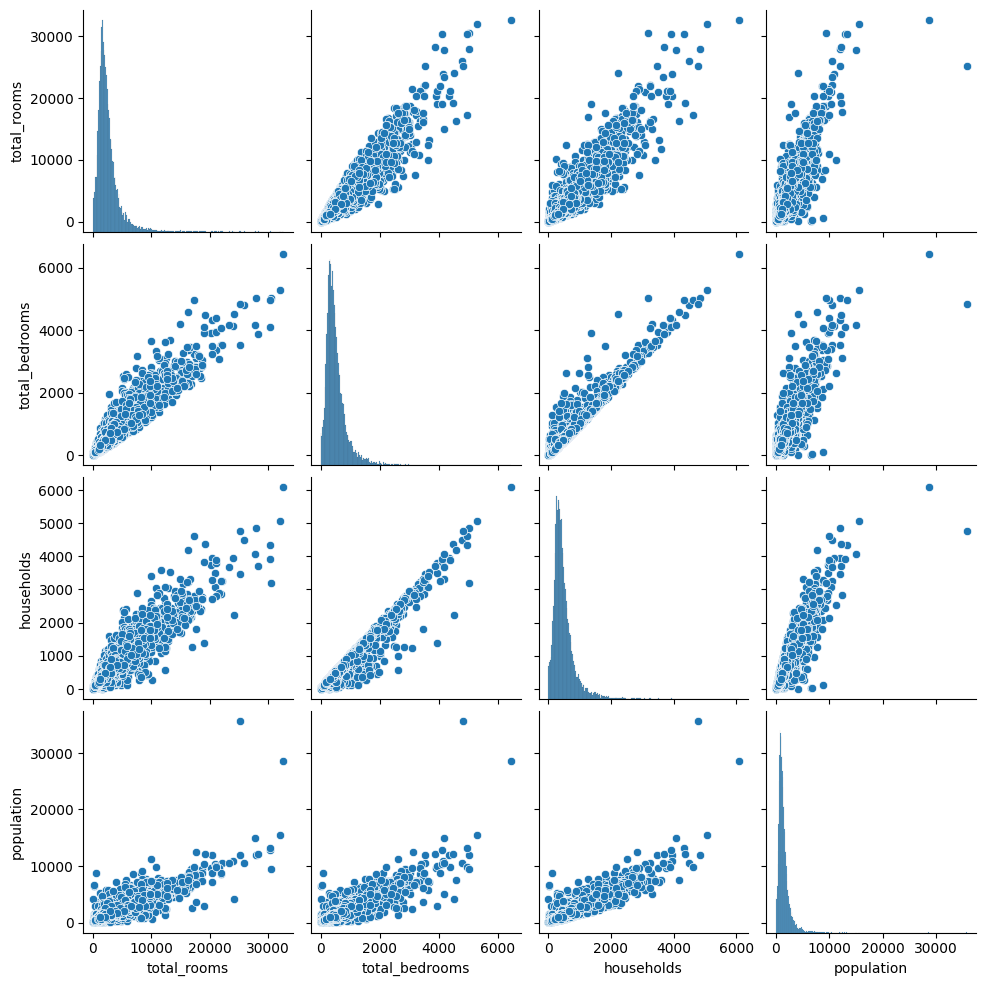

In [44]:
sns.pairplot(df[['total_rooms', 'total_bedrooms', 'households', 'population']])
plt.show()

Great, I think our hypothesis is right, there is a big correlation between (total rooms, total bedrooms, population, households, median income), so we can deal with it later using ratios between these features.

#### 1.3 Checking for Missing Data:

In [45]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [46]:
print(f"Percentage of missing values in total bedrooms: {(df['total_bedrooms'].isna().sum()/df.shape[0])*100}%")

Percentage of missing values in total bedrooms: 0.9568798449612402%


We have a missing values on total bedrooms, and it's very small percantage of our data, We can handle it using 2 methods:

1- Drop these rows, it's very small portion of our data.

2- As we have seen before their is a big correlation between total_bedrooms and other features and we can perdict the missing values by those.
We will handle it later.

### 2. EDA:

#### 2.1 Explore target varible (dependent variable):

In [47]:
df['median_house_value'].head()

12069    500001.0
15925    270000.0
11162    196100.0
4904     118800.0
4683     225000.0
Name: median_house_value, dtype: float64

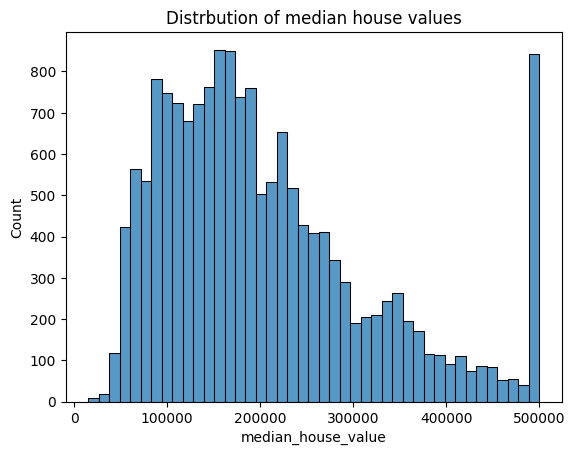

In [48]:
sns.histplot(df['median_house_value'])
plt.title('Distrbution of median house values')
plt.show()

I will remove the capped values at 500k $, because it can bad influnce our model.

In [49]:
df = df[df['median_house_value']<500000].copy()

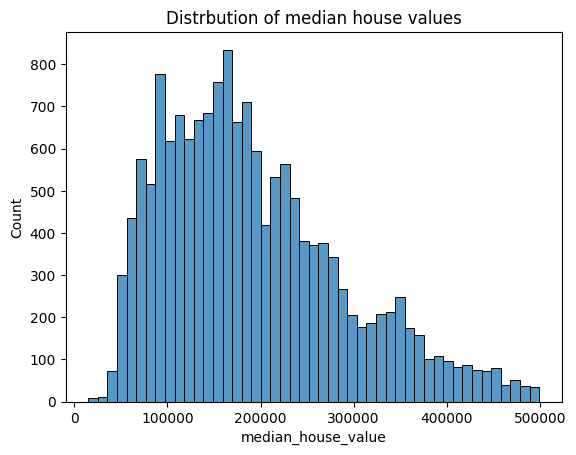

In [50]:
sns.histplot(df['median_house_value'])
plt.title('Distrbution of median house values')
plt.show()

#### 2.2 Explore indepandent varibles:

##### 2.2.1 ocean_proximity:

In [51]:
ocean_proximity_count = df['ocean_proximity'].value_counts().reset_index()

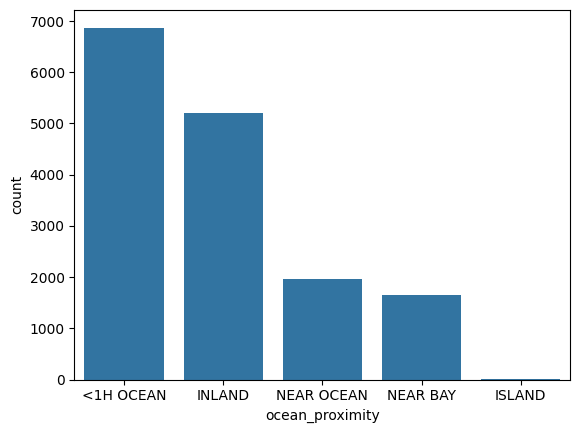

In [52]:
sns.barplot(ocean_proximity_count, x='ocean_proximity', y='count')
plt.show('ocean proximity categories count')
plt.show()

The most of our districts Inland or <1H from the Ocean, and we have very small numbers of districts in island, we will explore that more using lat, lon.

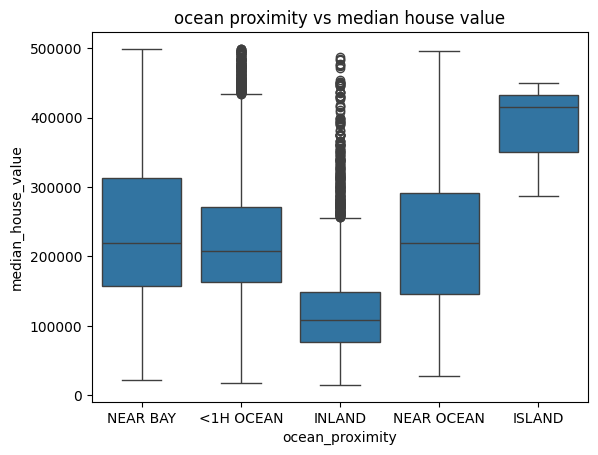

In [53]:
sns.boxplot(df, x='ocean_proximity', y='median_house_value')
plt.title('ocean proximity vs median house value')
plt.show()

We can see the districts in island are the most expensive, and Inland are the most cheap, and we can assume the ocean proximity is good predictor for our model.

Firstly we need to look on California map.


<img src="california-map.png" alt="Alt Text" width="500">

##### 2.2.2 longitude and latitude:

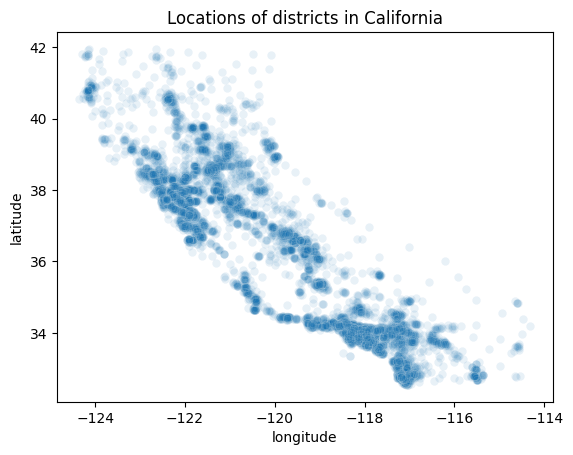

In [54]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=0.1)
plt.title("Locations of districts in California")
plt.show()

We can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

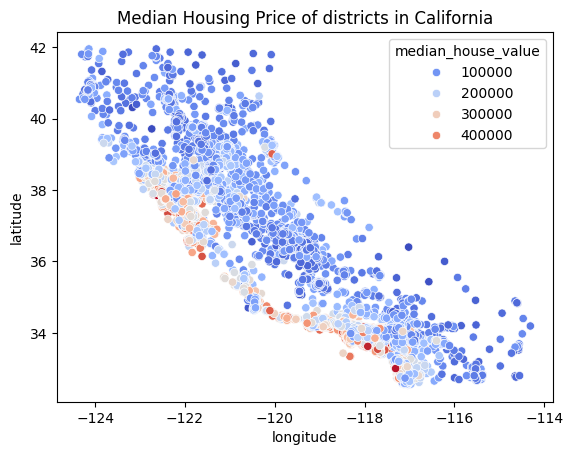

In [55]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=1, hue='median_house_value', palette='coolwarm')
plt.title("Median Housing Price of districts in California")
plt.show()

As ocean_proximity, as we get near to the ocean the median prices of houses increases, but latitude and longitude give more informantion, It's clearly that, there are districts are more expensive than others like (Los Angeles, San Fransisco).

There isn't a mathematical relation between (latitude, longitude) and median_housing_price, maybe we can cluster these discrit.

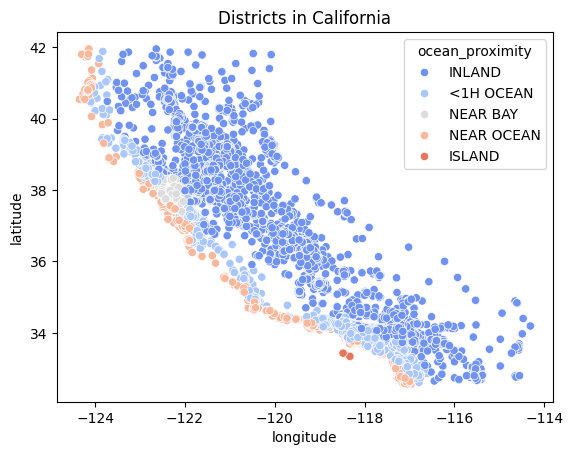

In [56]:
sns.scatterplot(df, x='longitude', y='latitude', alpha=1, hue='ocean_proximity', hue_order=['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND'],
                palette='coolwarm')
plt.title("Districts in California")
plt.show()

##### 2.2.3 other numerical variables:

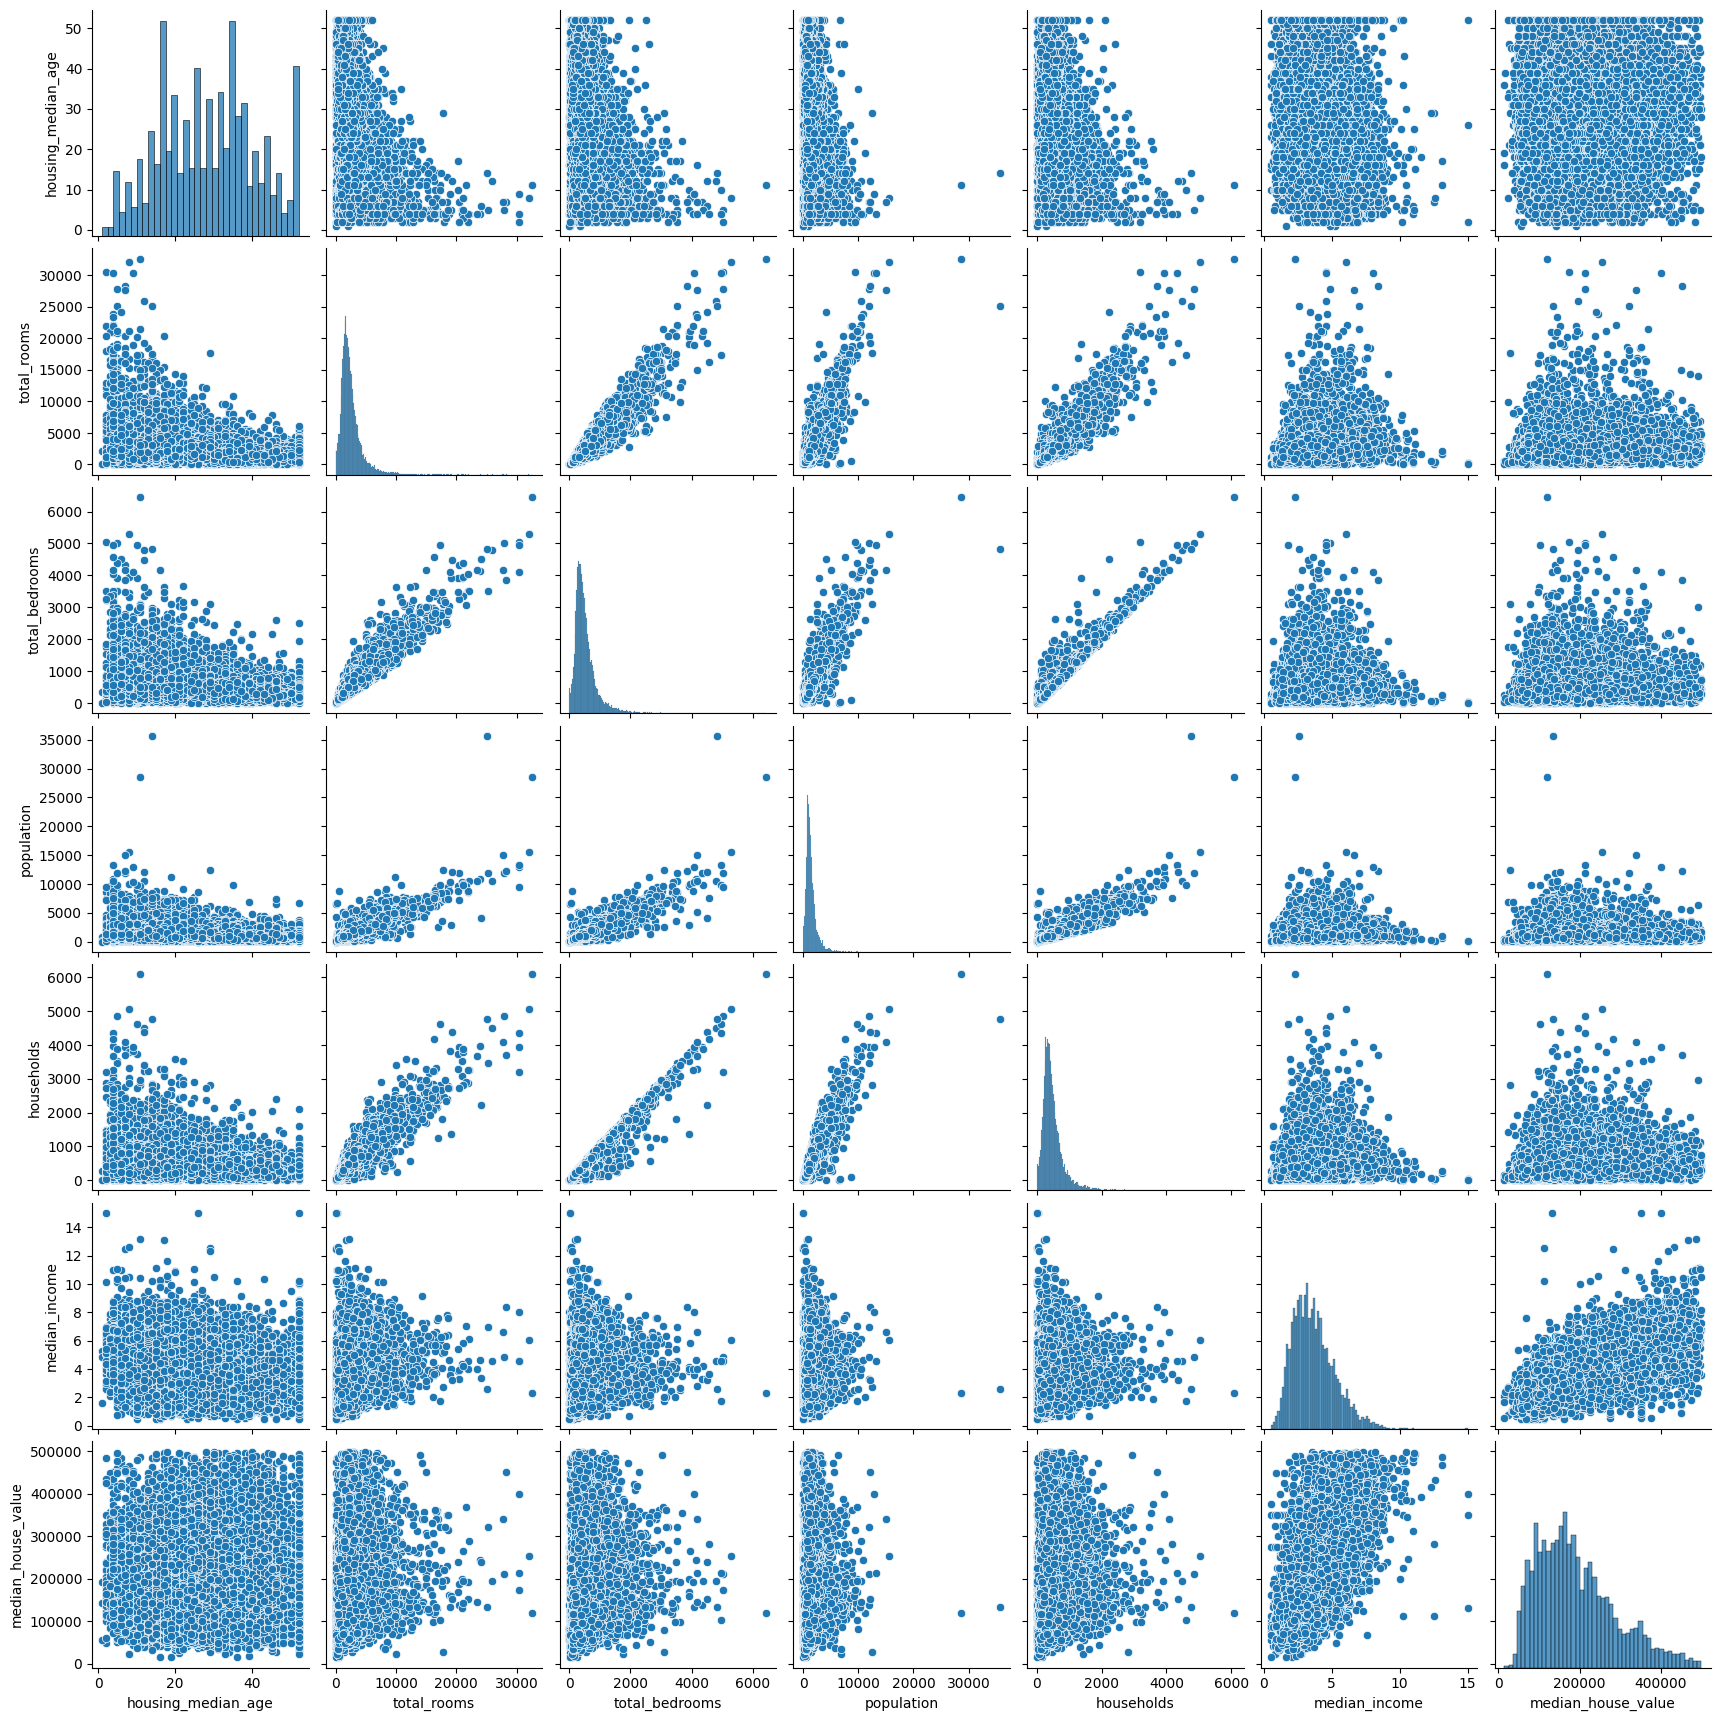

In [57]:
other_num = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
sns.pairplot(df[other_num])
plt.show()

In [58]:
correlation_matrix = df[other_num].corr()

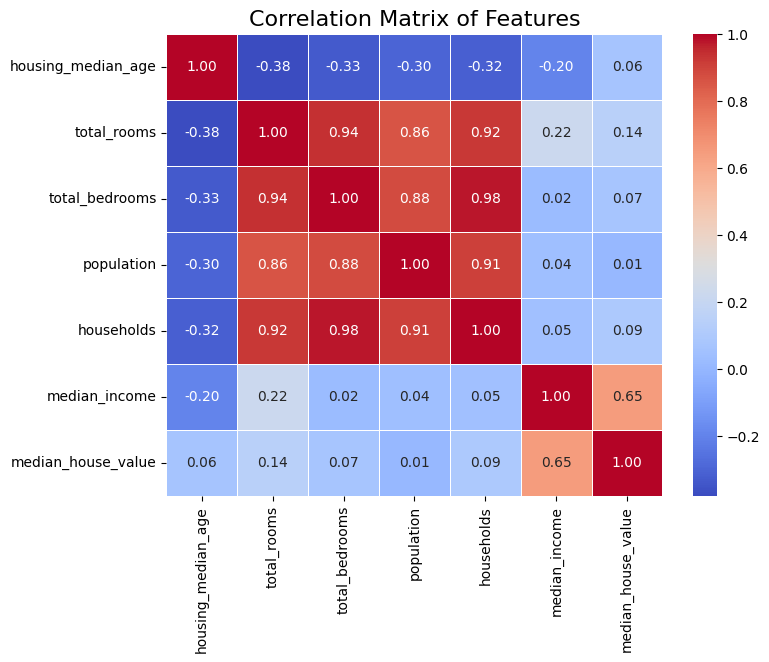

In [59]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


##### Some Insights:
- We have a very big correlations between (total_rooms, total_bedrooms, population, households) but they don't have correlation with median_house_value. (But I think with some scaling and feature engineering it will bring us with useful signals).
- Unexpectedly the housing_median_age seems like it's unuseful to predict median housing prices.
- We have a good correlation between median income and median house value.

### 3. Feature Engineering:

#### 3.1 Feature Exteraction:

I think the problem of the low correlations between (total_rooms, total_bedrooms, population, households) and median housing price is:

- The number of houses (households) or population in the district doesn't effect the house price, but the average number of people live in the same house might effect (population/households).

- The number of rooms of the district doesn't effect the house price, but the avarage number of rooms per house might effect.

So in the next section I will try to creaye more useful features for our target variable.

In [60]:
df['mean_people_per_house'] = df['population'] / df['households']
df['mean_rooms_per_house'] = df['total_rooms'] / df['households']
df['mean_bedrooms_per_house'] = df['total_bedrooms'] / df['households']
df['mean_people_per_room'] = df['population'] / df['total_rooms']
df['mean_people_per_bedroom'] = df['population'] / df['total_bedrooms']
df['total_bedrooms_total_rooms_ratio'] = df['total_bedrooms'] / df['total_rooms']

In [63]:
new_features = ['mean_people_per_house', 'mean_rooms_per_house', 'mean_bedrooms_per_house', 'mean_people_per_room',
                'mean_people_per_bedroom', 'total_bedrooms_total_rooms_ratio', 'median_house_value']

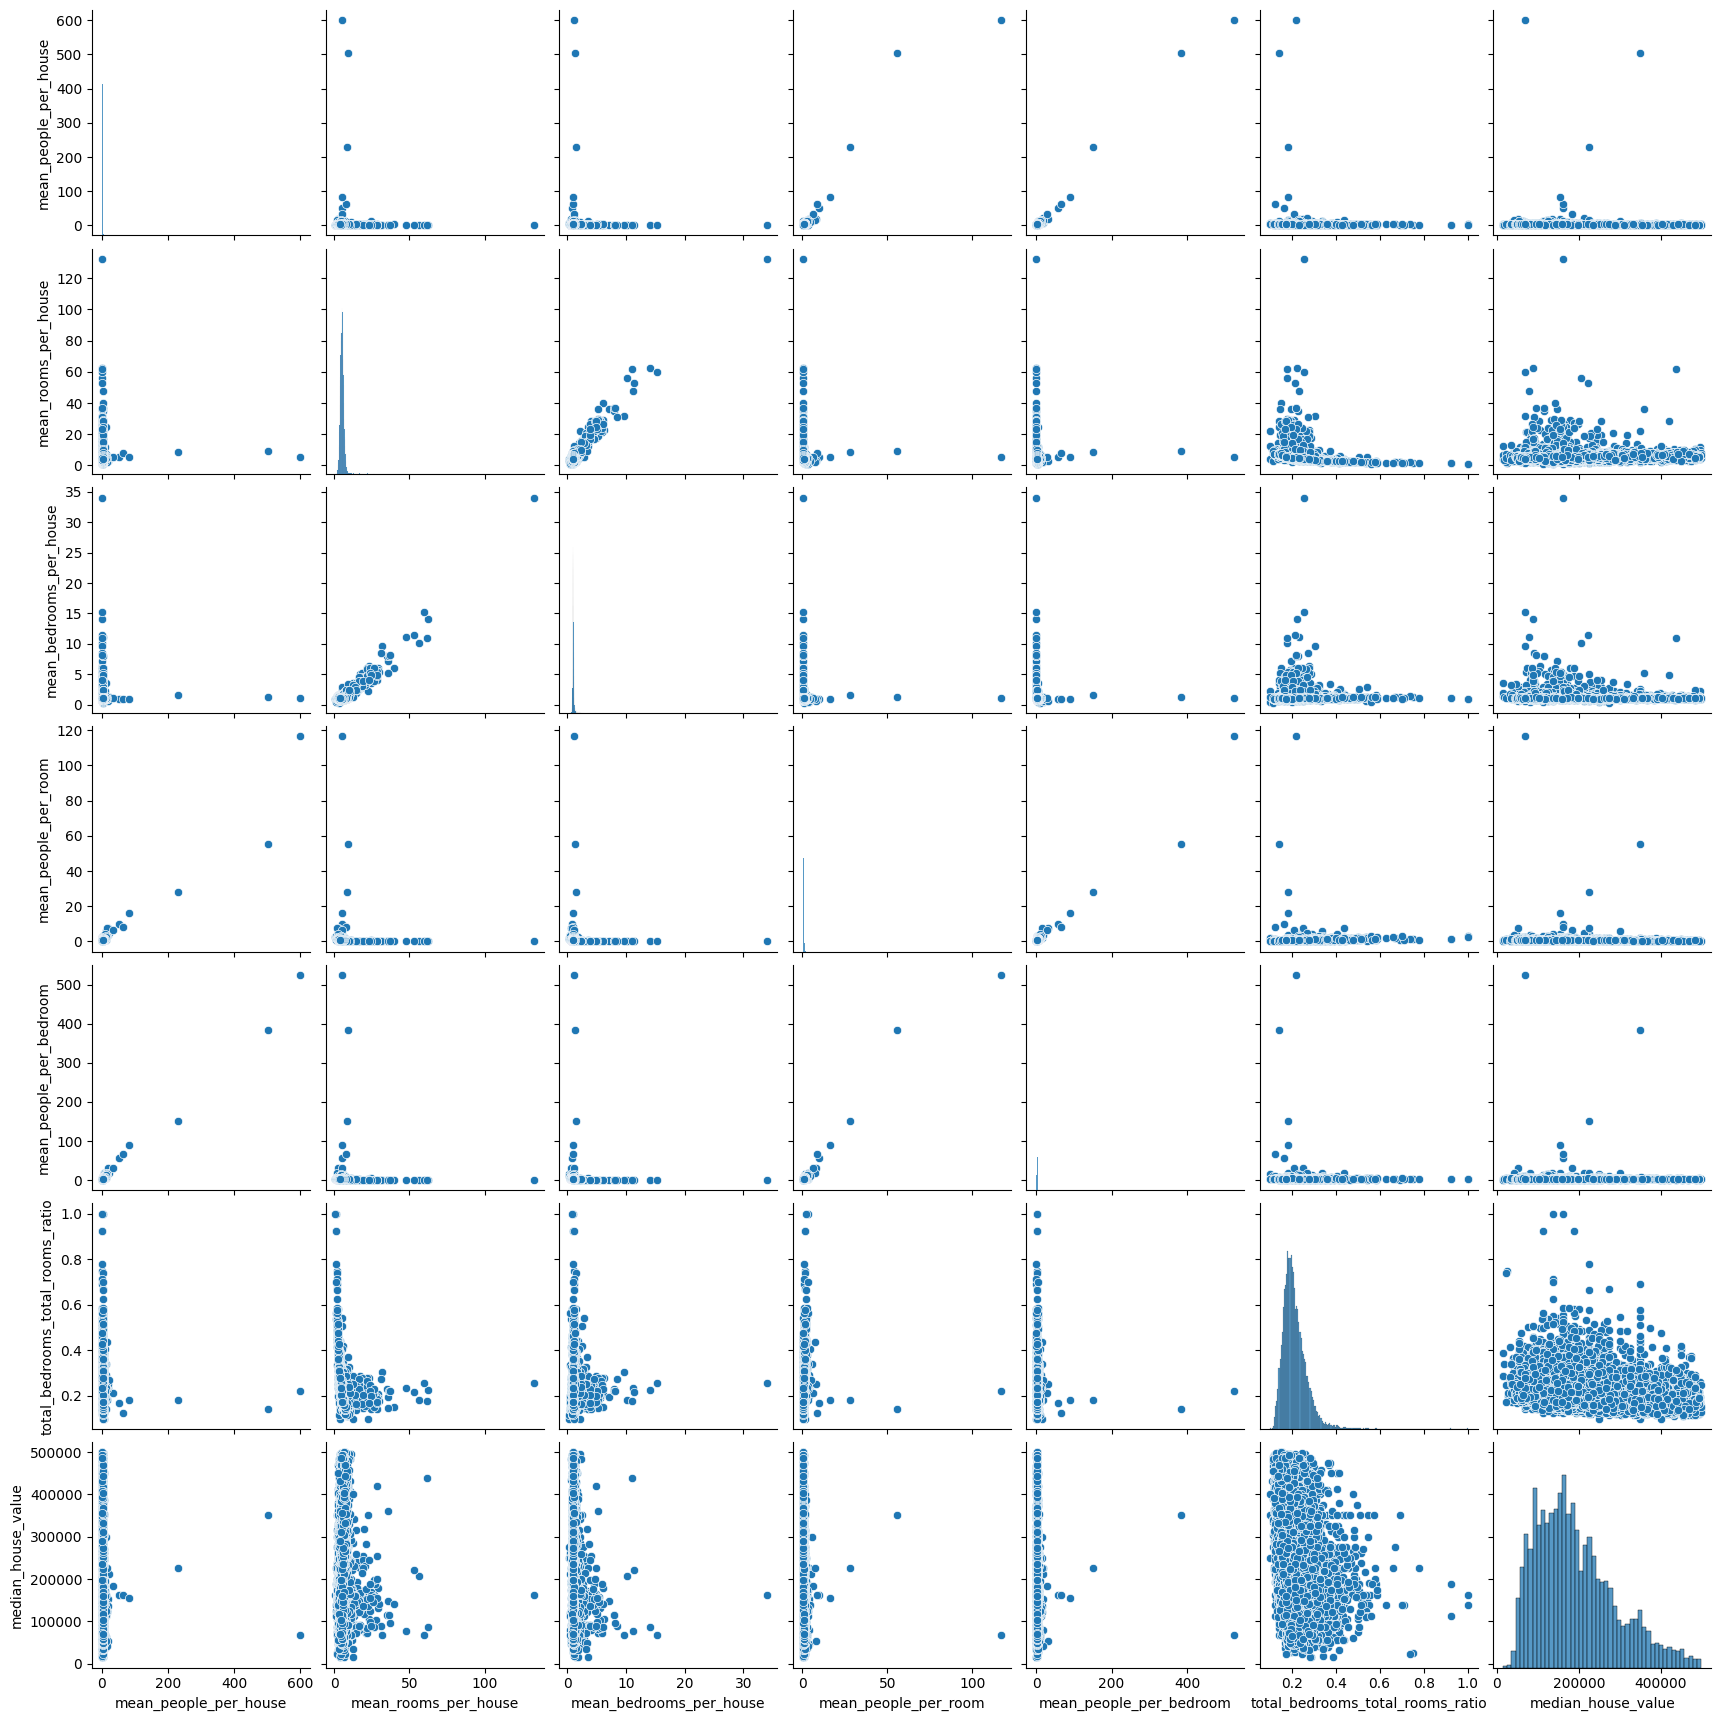

In [64]:
sns.pairplot(df[new_features])
plt.show()

In [65]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[new_features])
normalized_df = pd.DataFrame(normalized_data, columns=df[new_features].columns)

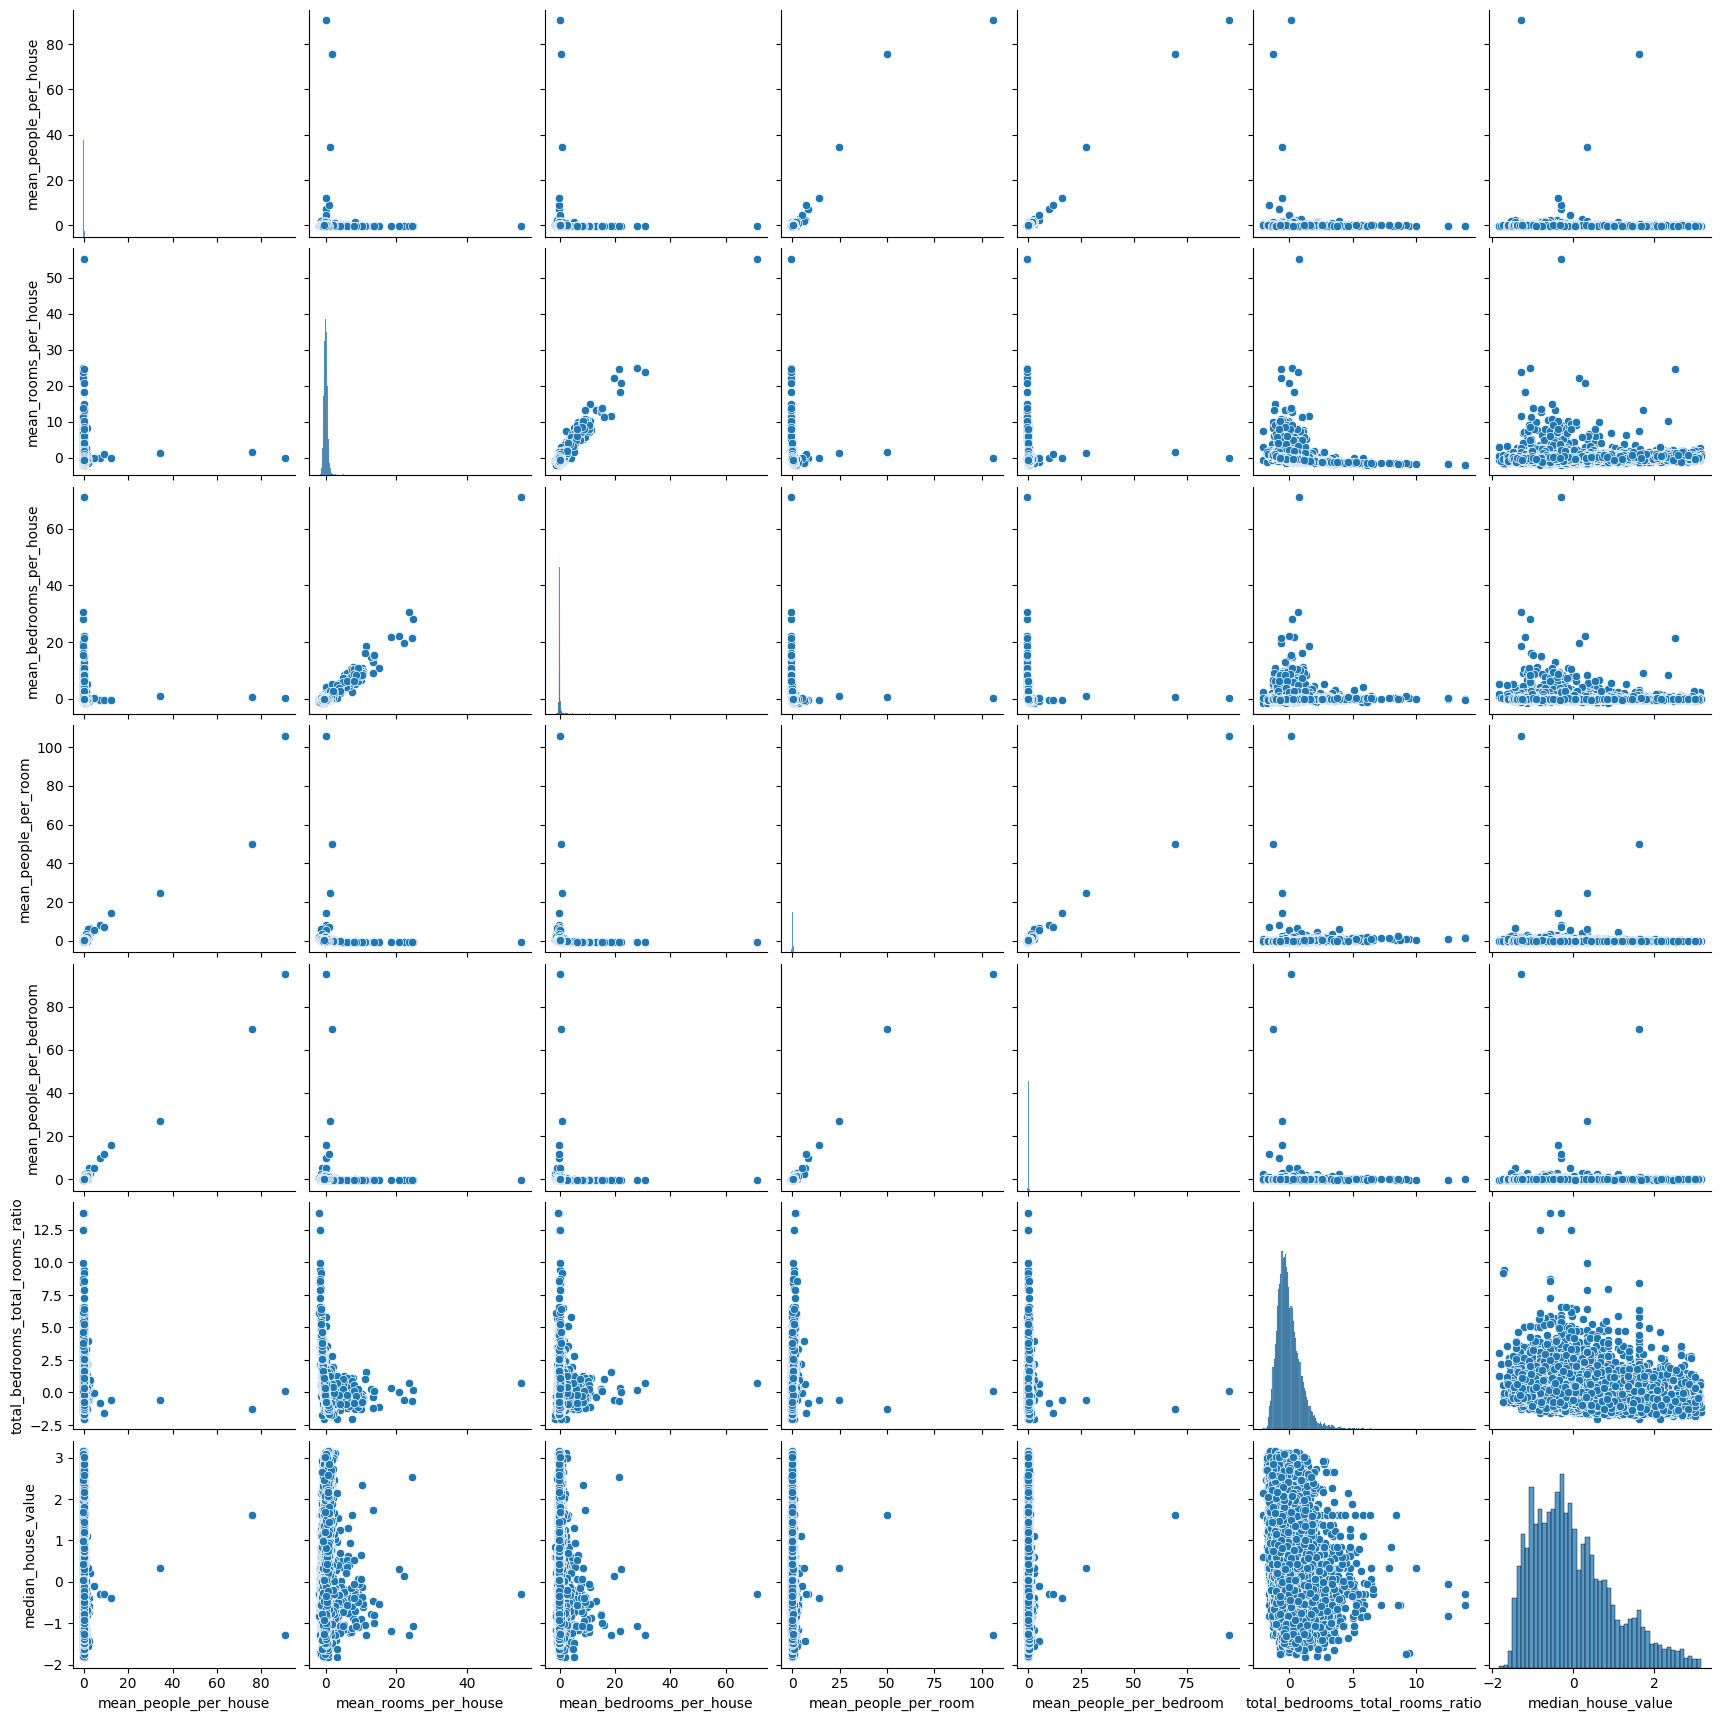

In [66]:
sns.pairplot(normalized_df)
plt.show()

In [67]:
correlation_matrix = normalized_df.corr()

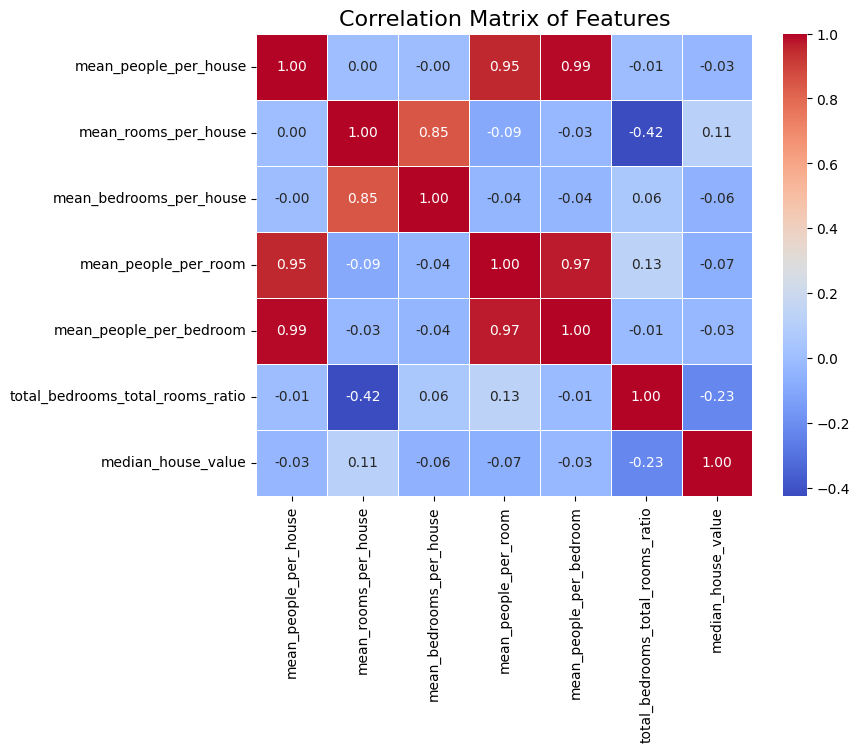

In [68]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


##### Insights:
1. mean_rooms_per_house, total_bedrooms_total_rooms_ration have some correlation with our target value.
2. But their are outliers decreased the correlations, we need to deal with them again.

#### 3.2 Dealing with outliers (Second try):

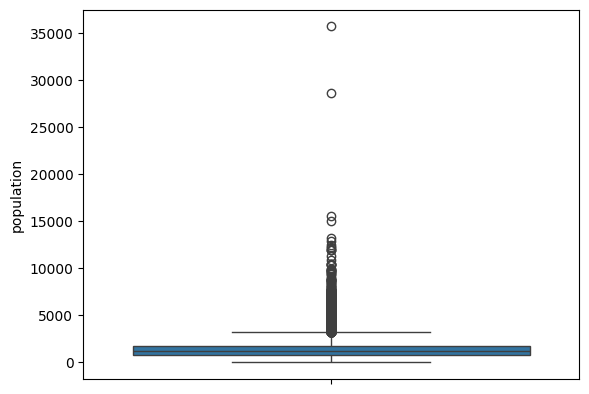

In [69]:
sns.boxplot(df['population'])
plt.show()

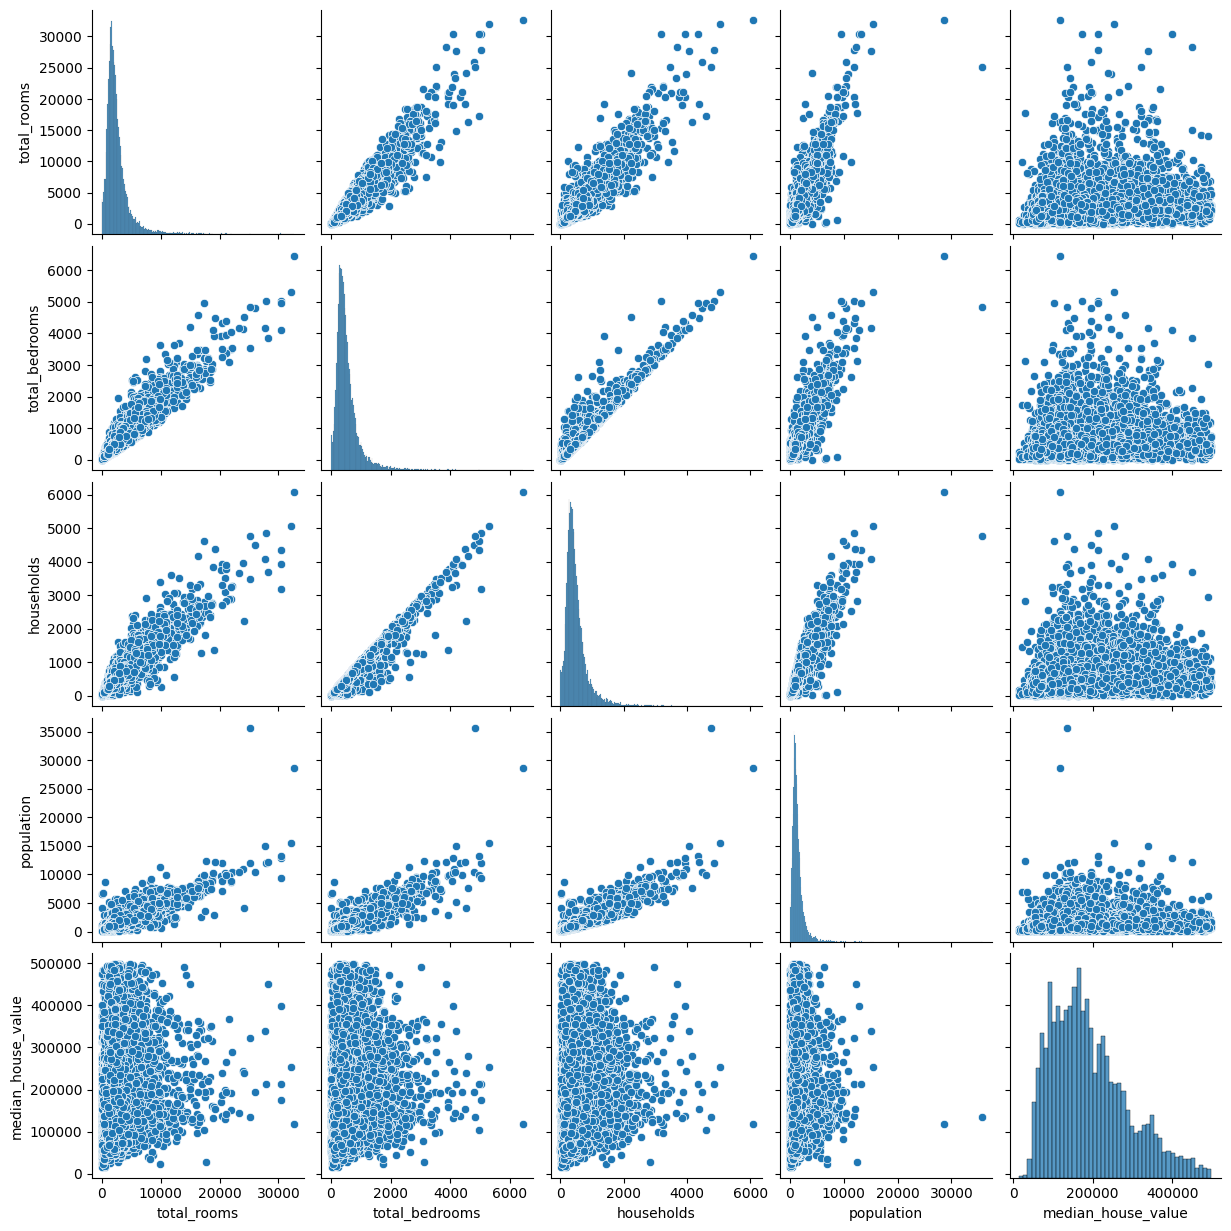

In [72]:
sns.pairplot(df[['total_rooms', 'total_bedrooms', 'households', 'population', 'median_house_value']])
plt.show()

##### Insights:
1. We have 2 points with very big numbers in the population column.
2. These 2 points not follow the pattern showed between population and (total_rooms, total_bedrooms, households).


let us get a closer look.

In [71]:
df[df['population']>20000]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
9880     -121.79     36.64                11.0      32627.0          6445.0   
15360    -117.42     33.35                14.0      25135.0          4819.0   

       population  households  median_income  median_house_value  \
9880      28566.0      6082.0         2.3087            118800.0   
15360     35682.0      4769.0         2.5729            134400.0   

      ocean_proximity  mean_people_per_house  mean_rooms_per_house  \
9880        <1H OCEAN               4.696810              5.364518   
15360       <1H OCEAN               7.482072              5.270497   

       mean_bedrooms_per_house  mean_people_per_room  mean_people_per_bedroom  \
9880                  1.059684              0.875533                 4.432273   
15360                 1.010484              1.419614                 7.404441   

       total_bedrooms_total_rooms_ratio  
9880                           0.197536  
15360                          0.191725

In [73]:
display(df[df['population']>20000].describe())
display(df[df['population']<20000].describe())

longitude   latitude  housing_median_age   total_rooms  \
count    2.000000   2.000000             2.00000      2.000000   
mean  -119.605000  34.995000            12.50000  28881.000000   
std      3.090057   2.326381             2.12132   5297.644005   
min   -121.790000  33.350000            11.00000  25135.000000   
25%   -120.697500  34.172500            11.75000  27008.000000   
50%   -119.605000  34.995000            12.50000  28881.000000   
75%   -118.512500  35.817500            13.25000  30754.000000   
max   -117.420000  36.640000            14.00000  32627.000000   

       total_bedrooms    population   households  median_income  \
count        2.000000      2.000000     2.000000       2.000000   
mean      5632.000000  32124.000000  5425.500000       2.440800   
std       1149.755626   5031.771855   928.431204       0.186818   
min       4819.000000  28566.000000  4769.000000       2.308700   
25%       5225.500000  30345.000000  5097.250000       2.374750   
50%       5632.000000  32124.000000  5425.500000       2.440800   
75%       6038.500000  33903.000000  5753.750000       2.506850   
max       6445.000000  35682.000000  6082.000000       2.572900   

       median_house_value  mean_people_per_house  mean_rooms_per_house  \
count            2.000000               2.000000              2.000000   
mean        126600.000000               6.089441              5.317508   
std          11030.865787               1.969477              0.066483   
min         118800.000000               4.696810              5.270497   
25%         122700.000000               5.393126              5.294002   
50%         126600.000000               6.089441              5.317508   
75%         130500.000000               6.785756              5.341013   
max         134400.000000               7.482072              5.364518   

       mean_bedrooms_per_house  mean_people_per_room  mean_people_per_bedroom  \
count                 2.000000              2.000000                 2.000000   
mean                  1.035084              1.147573                 5.918357   
std                   0.034790              0.384724                 2.101640   
min                   1.010484              0.875533                 4.432273   
25%                   1.022784              1.011553                 5.175315   
50%                   1.035084              1.147573                 5.918357   
75%                   1.047384              1.283594                 6.661399   
max                   1.059684              1.419614                 7.404441   

       total_bedrooms_total_rooms_ratio  
count                          2.000000  
mean                           0.194630  
std                            0.004109  
min                            0.191725  
25%                            0.193177  
50%                            0.194630  
75%                            0.196083  
max                            0.197536

longitude      latitude  housing_median_age   total_rooms  \
count  15703.000000  15703.000000        15703.000000  15703.000000   
mean    -119.553150     35.642872           28.343883   2619.112399   
std        2.006839      2.150930           12.508988   2164.927399   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.760000     33.930000           18.000000   1438.000000   
50%     -118.490000     34.260000           28.000000   2112.000000   
75%     -117.990000     37.720000           37.000000   3120.000000   
max     -114.310000     41.950000           52.000000  32054.000000   

       total_bedrooms    population    households  median_income  \
count    15551.000000  15703.000000  15703.000000   15703.000000   
mean       538.782136   1437.184869    500.394765       3.676480   
std        420.537587   1101.324841    380.390404       1.570742   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    793.000000    280.000000       2.526750   
50%        436.000000   1181.000000    411.000000       3.462000   
75%        647.000000   1746.000000    606.000000       4.583300   
max       5290.000000  15507.000000   5050.000000      15.000100   

       median_house_value  mean_people_per_house  mean_rooms_per_house  \
count        15703.000000           15703.000000          15703.000000   
mean        192215.264408               3.053660              5.361261   
std          97172.740677               6.594552              2.300290   
min          14999.000000               0.750000              0.846154   
25%         116700.000000               2.443988              4.422870   
50%         174000.000000               2.837310              5.186916   
75%         248000.000000               3.306435              5.972382   
max         499100.000000             599.714286            132.533333   

       mean_bedrooms_per_house  mean_people_per_room  mean_people_per_bedroom  \
count             15551.000000          15703.000000             15551.000000   
mean                  1.096172              0.613391                 2.876964   
std                   0.463367              1.095434                 5.494611   
min                   0.333333              0.018109                 0.070450   
25%                   1.005548              0.445034                 2.273345   
50%                   1.048780              0.523091                 2.698582   
75%                   1.100000              0.666771                 3.186427   
max                  34.066667            116.611111               524.750000   

       total_bedrooms_total_rooms_ratio  
count                      15551.000000  
mean                           0.214772  
std                            0.056817  
min                            0.100000  
25%                            0.177655  
50%                            0.204368  
75%                            0.240658  
max                            1.000000

We can see their is a big difference between the two distrbutions, I will try to remove these 2 rows and try again.

In [74]:
df2 = df[df['population']<20000].copy()

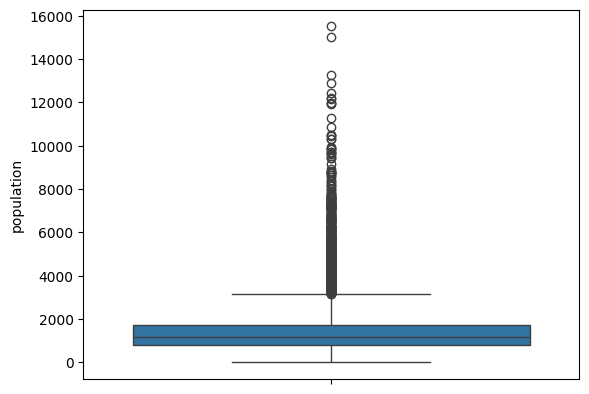

In [78]:
sns.boxplot(df2['population'])
plt.show()

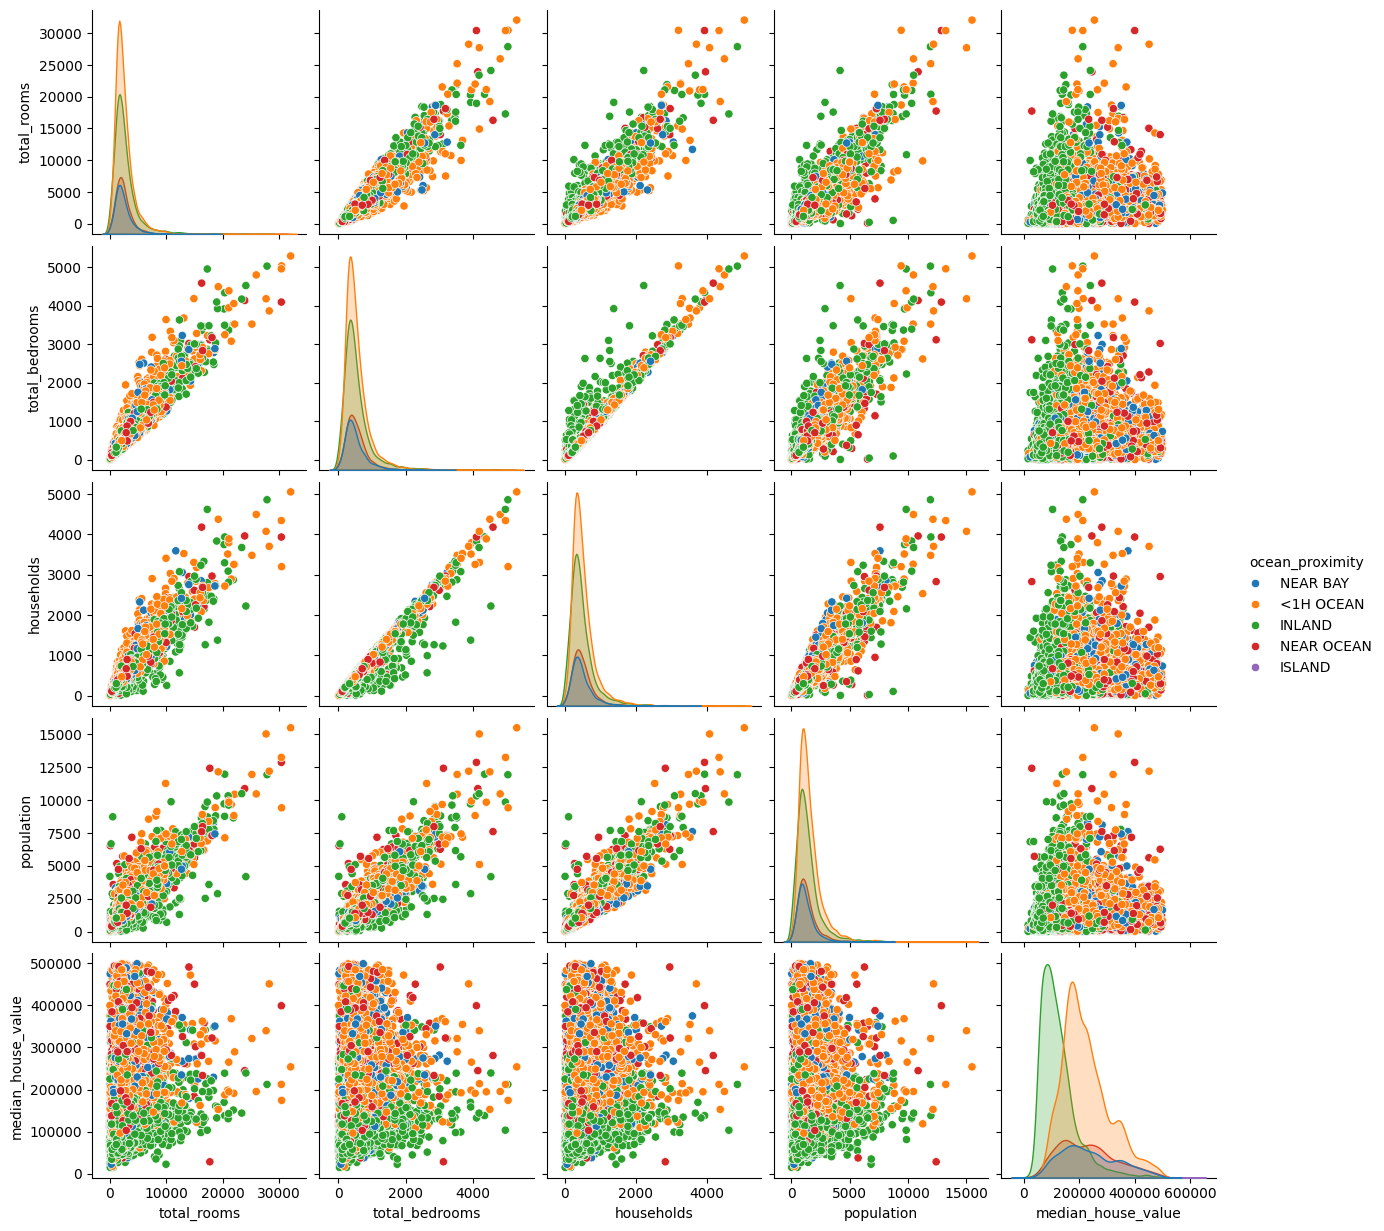

In [81]:
sns.pairplot(df2[['total_rooms', 'total_bedrooms', 'households', 'population', 'median_house_value', 'ocean_proximity']], hue='ocean_proximity')
plt.show()

In [82]:
df2['mean_people_per_house'] = df2['population'] / df2['households']
df2['mean_rooms_per_house'] = df2['total_rooms'] / df2['households']
df2['mean_bedrooms_per_house'] = df2['total_bedrooms'] / df2['households']
df2['mean_people_per_room'] = df2['population'] / df2['total_rooms']
df2['mean_people_per_bedroom'] = df2['population'] / df2['total_bedrooms']
df2['total_bedrooms_total_rooms_ratio'] = df2['total_bedrooms'] / df2['total_rooms']

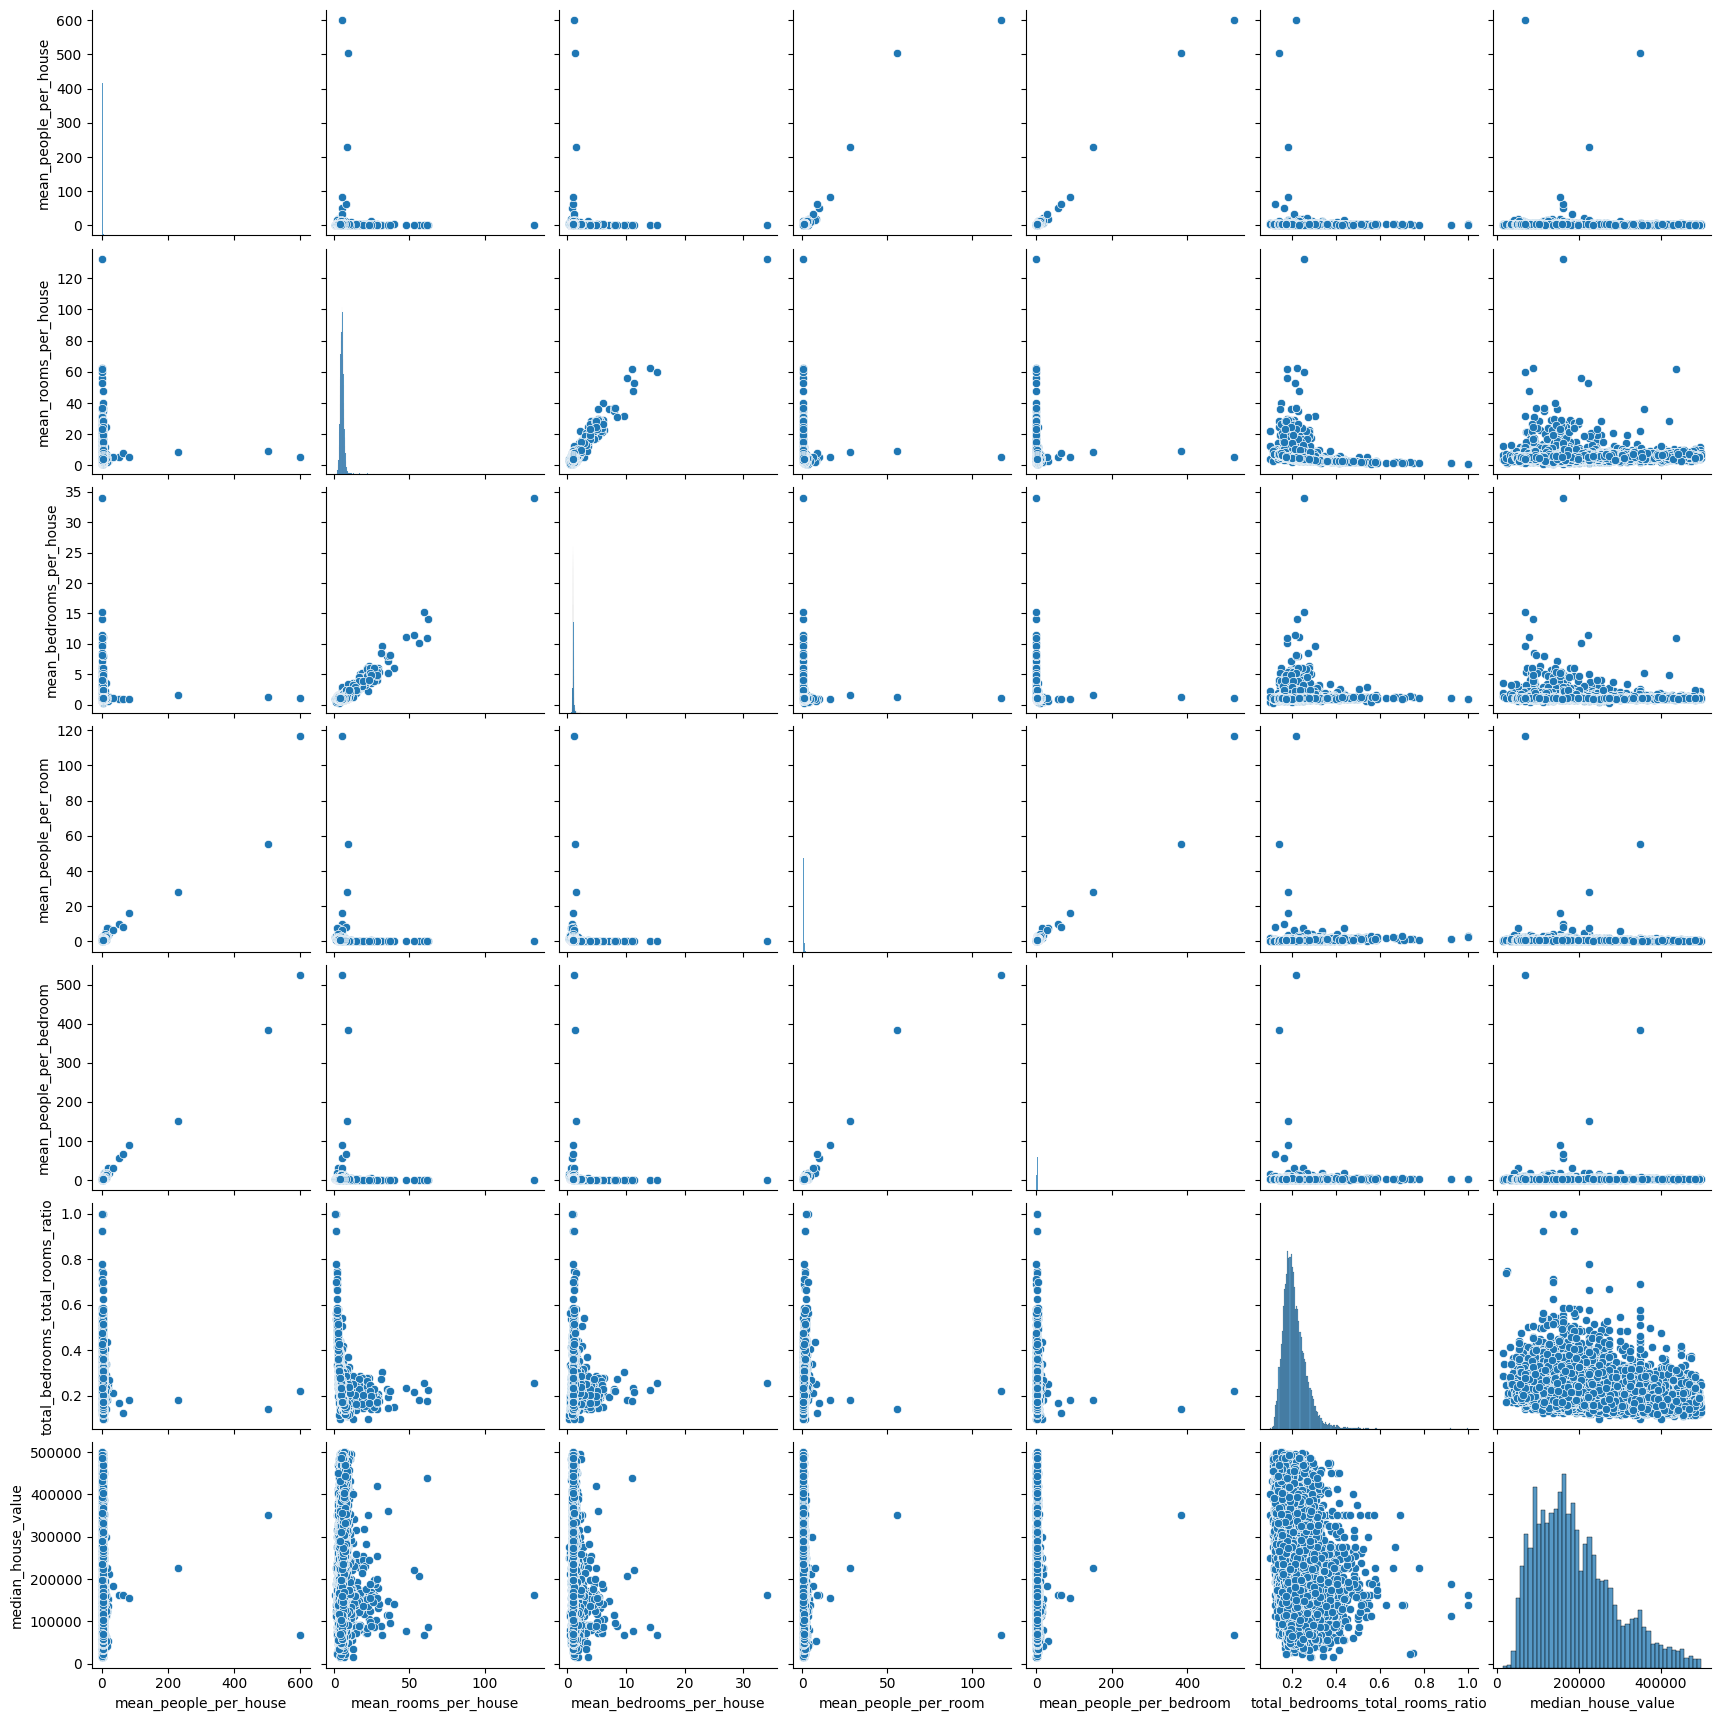

In [83]:
sns.pairplot(df2[new_features])
plt.show()

In [ ]:
new_features = ['mean_people_per_house', 'mean_rooms_per_house', 'mean_bedrooms_per_house', 'mean_people_per_room',
                'mean_people_per_bedroom', 'total_bedrooms_total_rooms_ratio']

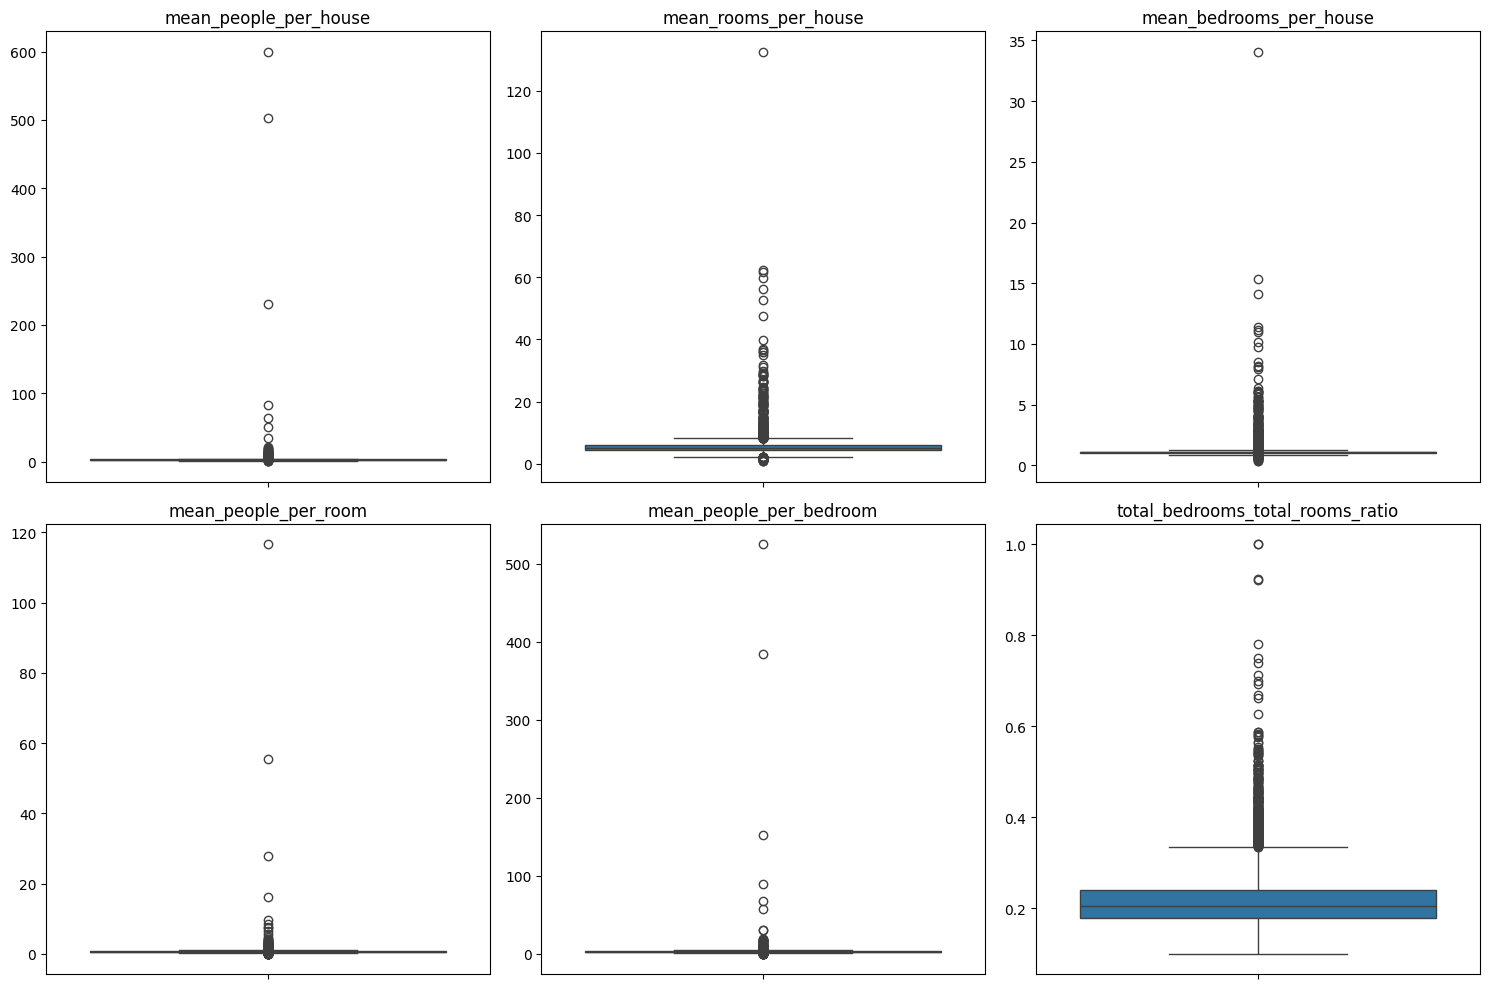

In [87]:
# Plot Histograms to know more about the numerical data distrbutions.
fig, axes = plt.subplots(2,3, figsize=(15, 10))

for name, ax in zip(new_features, axes.flatten()):
    sns.boxplot(df2[name], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
plt.tight_layout()
plt.show()

##### Insights:
1. There are very big ratios in (mean_people_per_room, mean_people_per_bedroom, mean_people_per_house) more than 20 people in the room, more than 50 bedroom.

In [91]:
df2[df2['mean_people_per_bedroom'] > 50].head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
16420    -121.29     37.89                26.0        161.0            27.0   
16669    -120.70     35.32                46.0        118.0            17.0   
12104    -117.33     33.97                 8.0        152.0            19.0   
13034    -121.15     38.69                52.0        240.0            44.0   
9172     -118.59     34.47                 5.0        538.0            98.0   
3364     -120.51     40.41                36.0         36.0             8.0   

       population  households  median_income  median_house_value  \
16420      1542.0        30.0         5.7485            162500.0   
16669      6532.0        13.0         4.2639            350000.0   
12104      1275.0        20.0         1.6250            162500.0   
13034      6675.0        29.0         6.1359            225000.0   
9172       8733.0       105.0         4.2391            154600.0   
3364       4198.0         7.0         5.5179             67500.0   

      ocean_proximity  mean_people_per_house  mean_rooms_per_house  \
16420          INLAND              51.400000              5.366667   
16669      NEAR OCEAN             502.461538              9.076923   
12104          INLAND              63.750000              7.600000   
13034          INLAND             230.172414              8.275862   
9172           INLAND              83.171429              5.123810   
3364           INLAND             599.714286              5.142857   

       mean_bedrooms_per_house  mean_people_per_room  mean_people_per_bedroom  \
16420                 0.900000              9.577640                57.111111   
16669                 1.307692             55.355932               384.235294   
12104                 0.950000              8.388158                67.105263   
13034                 1.517241             27.812500               151.704545   
9172                  0.933333             16.232342                89.112245   
3364                  1.142857            116.611111               524.750000   

       total_bedrooms_total_rooms_ratio  
16420                          0.167702  
16669                          0.144068  
12104                          0.125000  
13034                          0.183333  
9172                           0.182156  
3364                           0.222222

In [102]:
df3 = df2[df2['mean_people_per_bedroom'] < 5].copy()

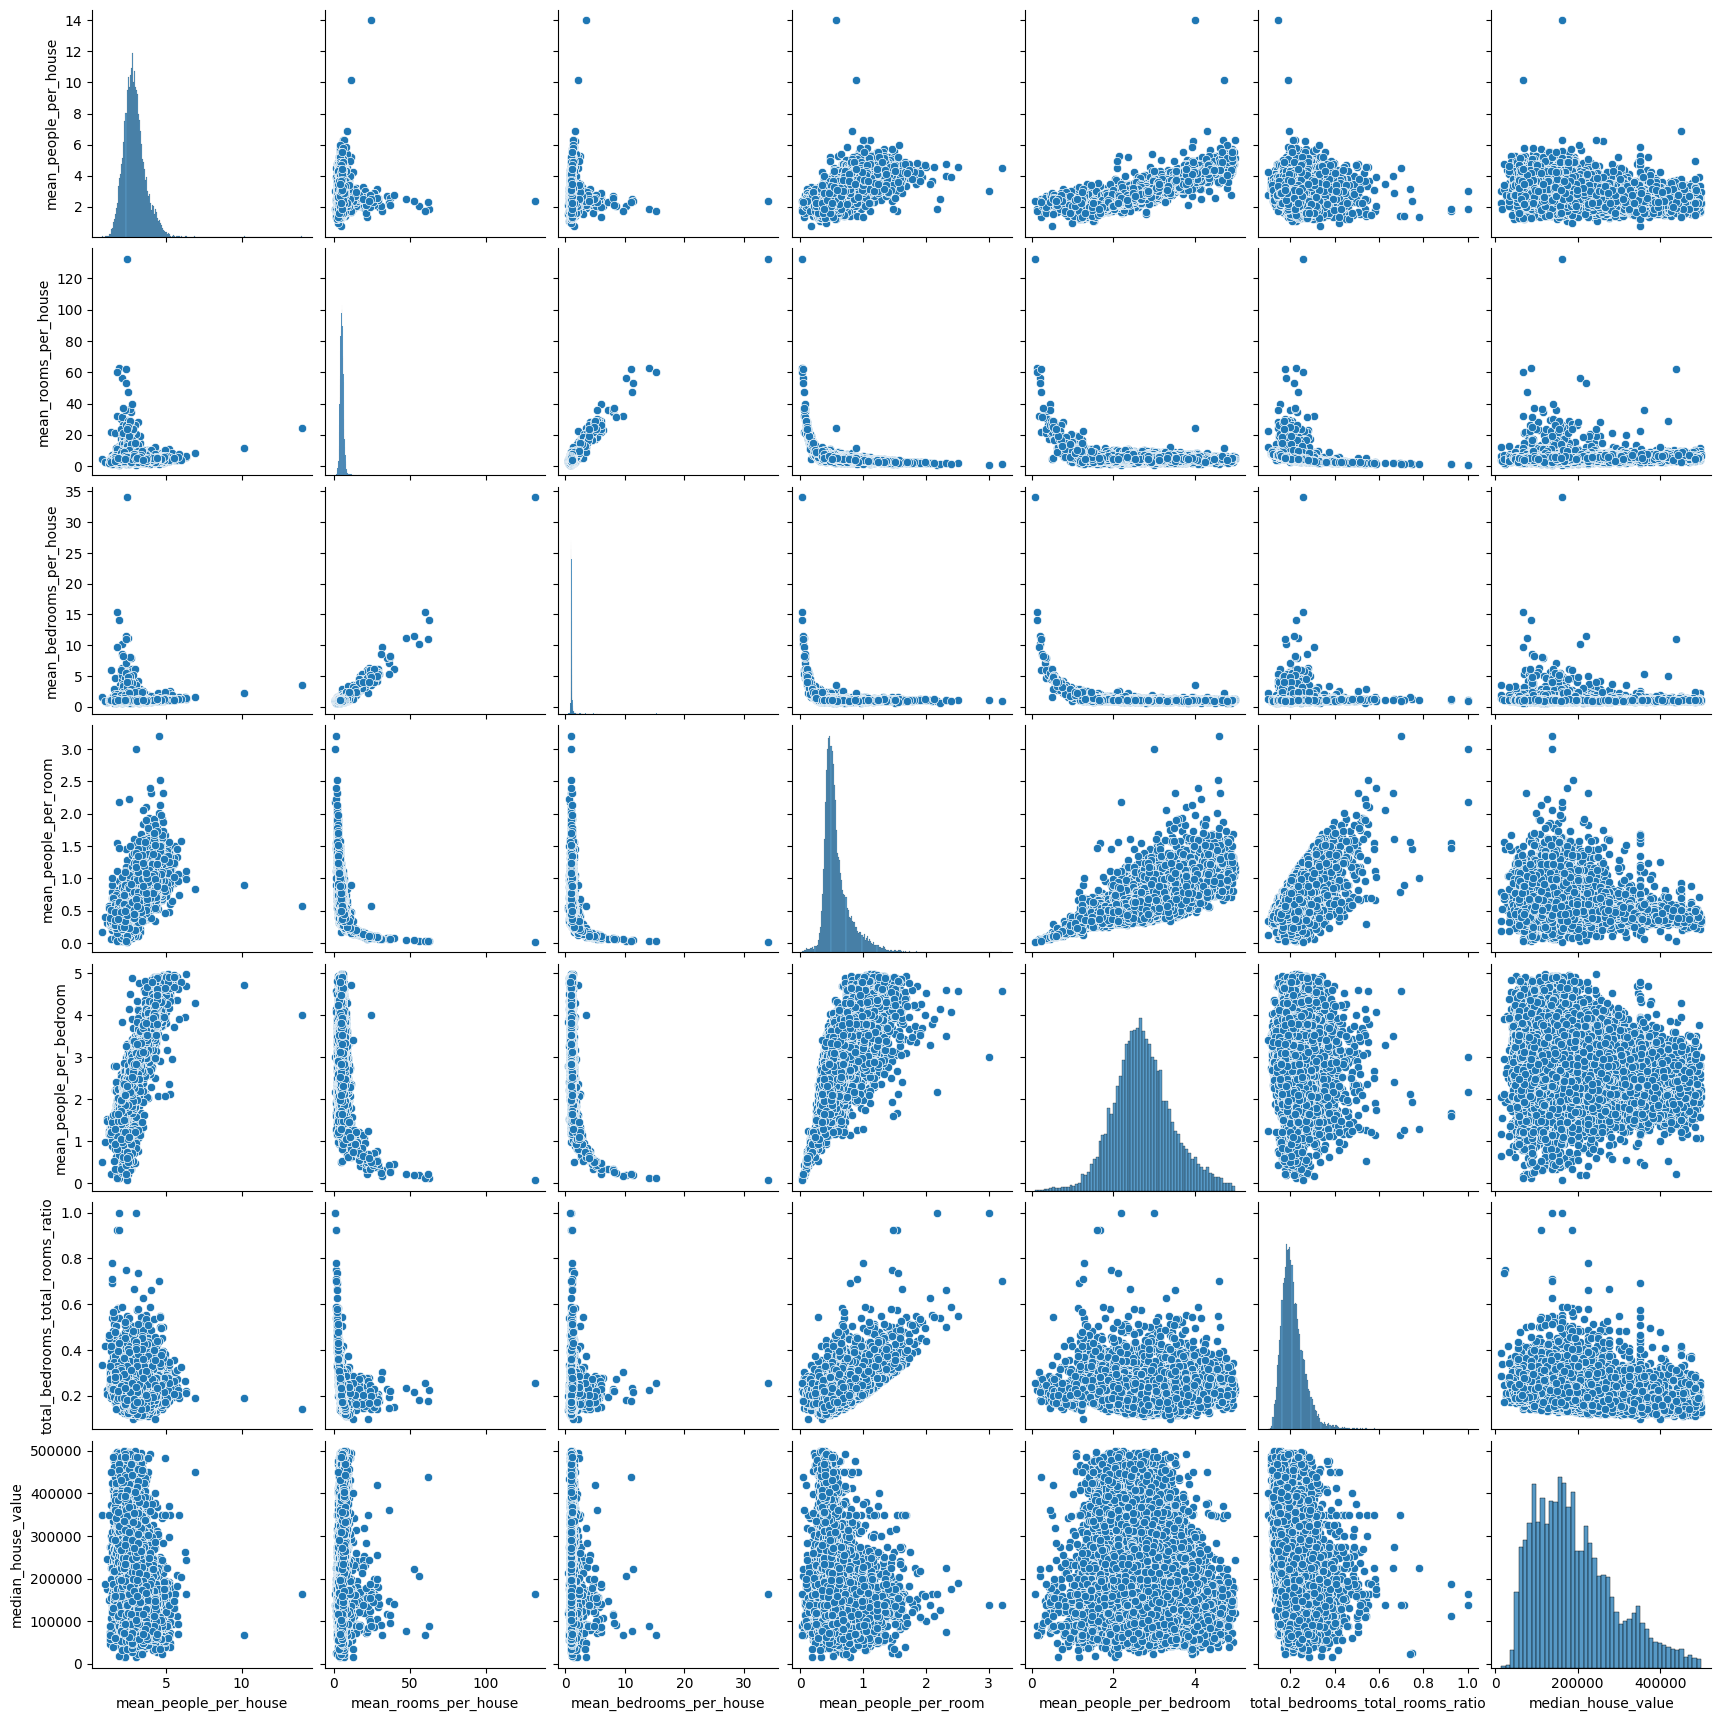

In [103]:
sns.pairplot(df3[new_features])
plt.show()

In [104]:
correlation_matrix = df3[new_features].corr()

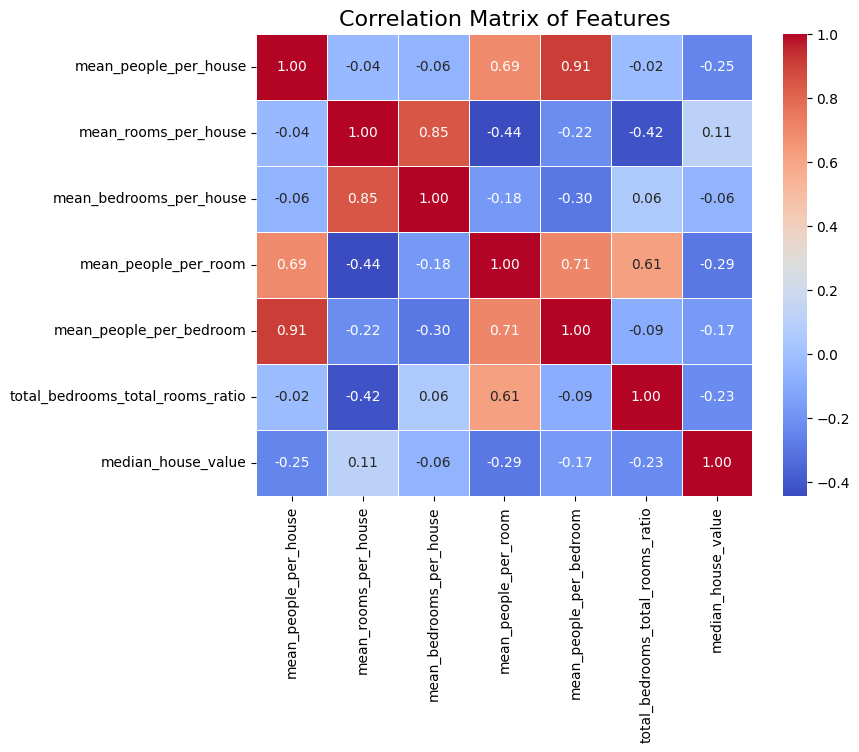

In [105]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


In [116]:
num_features = list(df3.columns)
num_features.remove('ocean_proximity')
print(num_features)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'mean_people_per_house', 'mean_rooms_per_house', 'mean_bedrooms_per_house', 'mean_people_per_room', 'mean_people_per_bedroom', 'total_bedrooms_total_rooms_ratio']


In [118]:
# Step 1: Calculate the Z-score
from scipy.stats import zscore

z_scores = np.abs(zscore(df3[num_features]))  # Calculate Z-scores for all columns
print("Z-scores:\n", z_scores)

# Step 2: Set a threshold and filter the data
threshold = 3
non_outliers = (z_scores < threshold).all(axis=1)


Z-scores:
 [[1.43282414 0.96413691 1.89274941 ... 0.18126181 0.38437205 0.135544  ]
 [0.77695721 0.84657763 0.18414486 ... 0.05363502 0.11231296 0.17287008]
 [0.6475556  0.76300619 0.77442172 ... 2.17882109 1.17998741 1.48558783]
 ...
 [0.66139146 0.84806546 0.10426431 ... 0.01797912 0.79354261 0.70456829]
 [0.81179611 0.94407764 0.45489953 ... 0.38856131 0.85252693 0.35399754]
 [1.99134156 1.32479198 1.0628309  ... 1.29220767 0.52591441 1.1620301 ]]


In [119]:
df_cleaned = df3[non_outliers]

In [124]:
correlation_matrix = df_cleaned[num_features].corr()

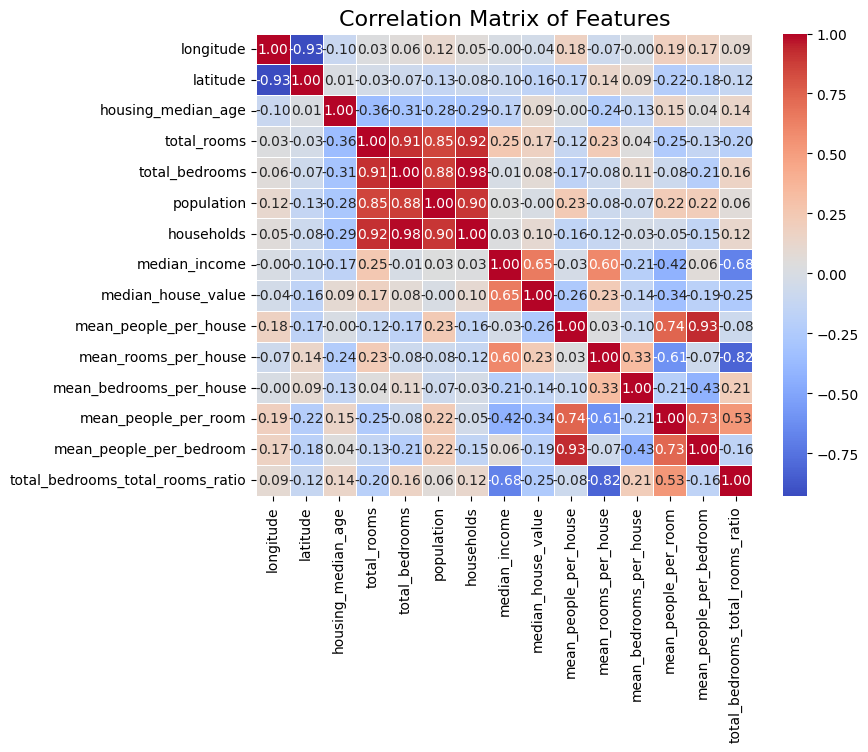

In [125]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


In [131]:
selected_features = ['median_income', 'mean_people_per_house', 'mean_rooms_per_house', 'mean_people_per_bedroom', 'total_bedrooms_total_rooms_ratio']

In [136]:
correlation_matrix = df_cleaned[selected_features+ ['median_house_value']].corr()

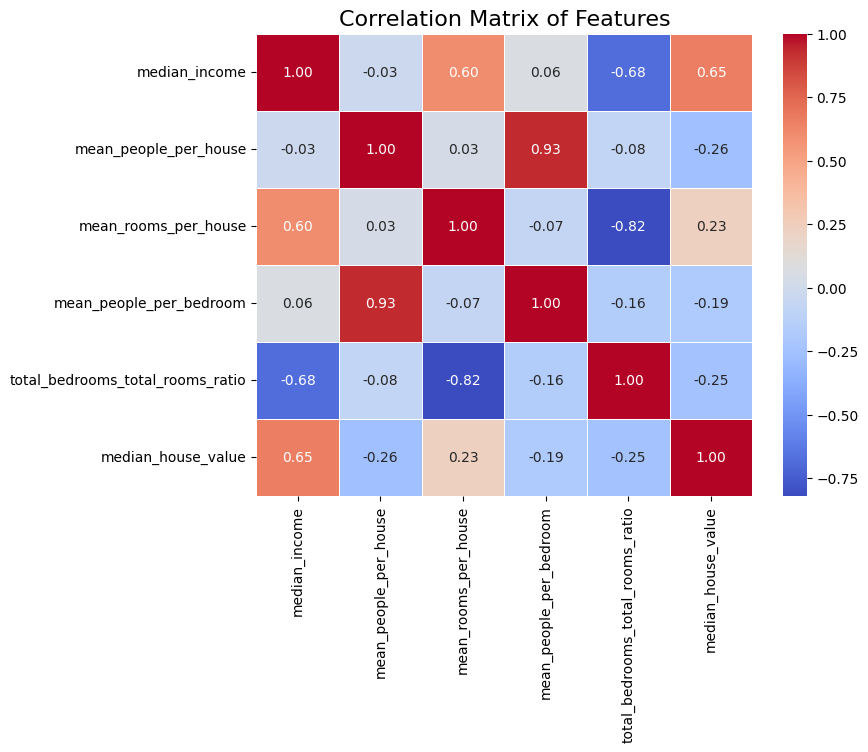

In [137]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


In [140]:
selected_features = ['median_income', 'mean_people_per_house', 'ocean_proximity']

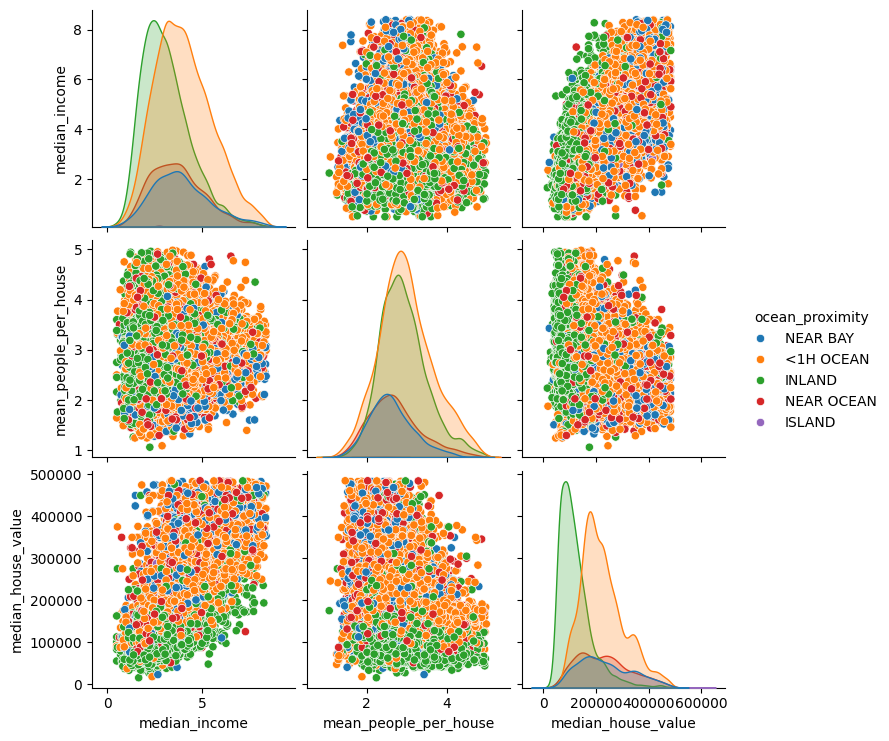

In [142]:
sns.pairplot(df_cleaned[selected_features + ['median_house_value']], hue='ocean_proximity')
plt.show()

In [146]:
X = df_cleaned[selected_features]
X = pd.get_dummies(X)
y = df_cleaned['median_house_value']

In [148]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [151]:
lr.score(X, y)

0.6132793236033662

In [160]:
test_set['mean_people_per_house'] = test_set['population'] / test_set['households']
y_test = test_set['median_house_value']
X_test = pd.get_dummies(test_set[selected_features])
X_test.head()

median_income  mean_people_per_house  ocean_proximity_<1H OCEAN  \
14740         4.1518               4.180593                      False   
10101         5.7796               3.020979                       True   
20566         4.3487               2.910112                      False   
2670          2.4511               2.746479                      False   
15709         5.0049               1.712401                      False   

       ocean_proximity_INLAND  ocean_proximity_ISLAND  \
14740                   False                   False   
10101                   False                   False   
20566                    True                   False   
2670                     True                   False   
15709                   False                   False   

       ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
14740                     False                        True  
10101                     False                       False  
20566                     False                       False  
2670                      False                       False  
15709                      True                       False

In [156]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [162]:
train_predict = lr.predict(X)
test_predict = lr.predict(X_test)

In [165]:
mse = mean_squared_error(y, train_predict)
r2 = r2_score(y, train_predict)
print('Train RMSE:', np.sqrt(mse))
print('Train R2 score', r2)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, test_predict)))
print('Test R2 score', r2_score(y_test, test_predict))

Train RMSE: 59442.385627548036
Train R2 score 0.6132793236033662
Test RMSE: 660748.4213169491
Test R2 score -32.481869311416354
